# Import and Functions

In [284]:
#  Load the "autoreload" extension so that code can change
%load_ext autoreload
%reload_ext autoreload

#  always reload modules so that as you change code in src, it gets loaded
%autoreload 2
%matplotlib inline

import sys
sys.path.append('../')
from src.features.map_dataset import MapDataset
from src.visualization.mapper import *

from shapely.geometry import Polygon, MultiPoint, Point, MultiPolygon
from scipy.stats import poisson, gamma, nbinom
plt.rcParams.update({'font.size': 16})
matplotlib.rc('font', family='Arial')

import statsmodels.api as sm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [104]:
def cal_1z_test(row1, row2):
    """Compare two rate and return the z-score
    
    z = (p1 - p2)/sqrt(p(1-p)(1/n1 + 1/n2))
    
    """
    # calculate 1 sample z-test 
    p1 = row1['rate']
    n1 = row1['pop']
    p2 = row2['rate']
    n2 = row2['pop']

    p = (p1*n1 + p2*n2)/(n1+n2)

    z = (p1-p2)/np.sqrt(p*(1 - p) * (1/n1 + 1/n2))

    return z

In [260]:
def load_lit_rate():
    lit_rate = pd.read_csv(mdataset.health_folder  + 'process/18_literacy_2008.csv')
    lit_rate = lit_rate.rename(columns={'rate':'lit_rate'})
    return lit_rate.drop_duplicates()

In [261]:
def load_smoke():
    smoke = pd.read_csv(mdataset.health_folder  + 'process/smoke.csv')
    smoke['year'] = smoke['year'].astype(int)

    # remove strange year 
    smoke = smoke[~smoke['year'].isin([2001, 2014])]
    smoke = smoke.set_index(['region', 'gender', 'year'])

    # calculate the rate 
    smoke['total'] = smoke.sum(axis=1)
    smoke['smoke_rate'] = smoke['frequent']/smoke['total']

    smoke = smoke[['smoke_rate']].reset_index()

    # separate into male and female
    smoke_male = smoke[smoke['gender'] == 'Male']

    smoke_female = smoke[smoke['gender'] == 'Female']
    # remove data after year 2012 for female 
    smoke_female = smoke_female[smoke_female['year'] < 2012]

    # fill missing value 

    temp_male = []
    for region in smoke_male['region'].unique():
    
        df = smoke_male[smoke_male['region'] == region]
        df = df.set_index('year')
        missing_year = [y for y in np.arange(2000, 2021) if y not in df.index]
        df = pd.concat([df, pd.DataFrame(index=missing_year)])
        df = df.sort_index()
        df = df.fillna(method='ffill')
        df = df.fillna(df.mean())
        df = df.fillna(method='bfill')
        
        df['smoke_rate'] = df['smoke_rate'].round(2)
        df.index.name = 'year'
        temp_male.append(df.reset_index())
    
    temp_male = pd.concat(temp_male)

    temp_female = []
    for region in smoke_female['region'].unique():
    
        df = smoke_female[smoke_female['region'] == region]
        df = df.set_index('year')
        missing_year = [y for y in np.arange(2000, 2021) if y not in df.index]
        df = pd.concat([df, pd.DataFrame(index=missing_year)])
        df = df.sort_index()
        df = df.fillna(method='ffill')
        df = df.fillna(df.mean())
        df = df.fillna(method='bfill')
        
        df['smoke_rate'] = df['smoke_rate'].round(2)
        df.index.name = 'year'
        temp_female.append(df.reset_index())
    
    temp_female = pd.concat(temp_female)

    smoke_rate = pd.concat([temp_male, temp_female])
    
    
    return smoke_rate.drop_duplicates()

In [262]:
def load_income():
    income = pd.read_csv(mdataset.health_folder  + 'process/income_98_19.csv')
    income = income.drop('thaiprov', axis=1)

    #remove region
    income = income[~income['province'].isin(['Whole Kingdom', 'Greater Bangkok', 'Northeastern Region', 'Northern Region',  'Central Region', 'Southern Region'])]


    income = income.set_index('province')

    income_avg = income.mean(axis=0) 

    # normalized by national avg 

    for year in income.columns:
        income[year] /= income_avg[year]
        income[year] = income[year].round(2)
    
    add_col = [ s for s in np.arange(2000, 2021).astype(str) if s not in income.columns]

    for col in add_col:
        income[col] = np.nan
  
    # reorder columns
    income = income.reindex(sorted(income.columns), axis=1)

    # Fill missing year
    income = income.fillna(method = 'ffill', axis=1)
    
    income = income.melt(ignore_index=False, value_name = 'income', var_name='year').reset_index()

    income['year'] = income['year'].astype(int)
    return income.drop_duplicates()

In [263]:
def load_pop_avg():
    pop = population.melt(id_vars=['province', 'gender'], var_name='year', value_name='pop')
    pop['year'] = pop['year'].astype(int)

    pop_mean = pop.groupby(['year', 'gender'], as_index=False).mean()
    pop_mean = pop_mean.rename(columns={'pop': 'avg_pop'})
    pop_sum = pop.groupby(['year', 'gender'], as_index=False).sum()
    pop_sum = pop_sum.rename(columns={'pop': 'sum_pop'})

    pop_avg = pop.merge(pop_mean, on = ['year', 'gender'], how='left')
    pop_avg = pop_avg.merge(pop_sum, on = ['year', 'gender'], how='left' )

    pop_avg['pop_per_avg'] = (pop_avg['pop']/pop_avg['avg_pop']).round(2)
    pop_avg['pop_per_sum'] = (pop_avg['pop']/pop_avg['sum_pop']*100).round(2)

    pop_avg = pop_avg[['province', 'gender', 'year', 'pop_per_avg', 'pop_per_sum']]
    
    pop_avg['year'] = pop_avg['year'].astype(int)
    return pop_avg.drop_duplicates()

In [264]:
def load_pop_ratio():
    
    pop_ratio = pd.read_csv(mdataset.health_folder  + 'process/pop_per_age_group_no_infant.csv')
    
    pop_ratio['year'] = pop_ratio['year'].astype(int)
    return pop_ratio.drop_duplicates()

In [265]:
def build_data(illness_data, poll_data):
    
    data = illness_data[['gender', 'province', 'year', 'pop', 'birth_number', 'region', 'rate', 'birth_rate']].drop_duplicates()
    
    
    # merge with pollution 
    data = data.merge(poll_data.dropna(), on=['year', 'province'], how='inner')
    
    # merge with income
    income = load_income()
    data = data.merge(income.dropna(), on=['year', 'province'], how='inner')
    
    # merge with pop_ratio
    pop_ratio = load_pop_ratio()
    data = data.merge(pop_ratio.dropna(), on=['year', 'province', 'gender'], how='inner')
    
    # merge with province pop size
    pop_avg = load_pop_avg()
    data = data.merge(pop_avg.dropna(), on=['year', 'province', 'gender'], how='inner')
    
    # merge with smoke_rate
    smoke_rate = load_smoke()
    data = data.merge(smoke_rate.dropna(), on=['year', 'region', 'gender'], how='inner')
    
    # merge with literacy rate
    lit_rate = load_lit_rate()
    data = data.merge(lit_rate.dropna(), on=['region'], how='inner')
    
    
    print('data shape', data.shape)
    return data.drop_duplicates()

In [339]:
def build_data_no_gender(illness_data, poll_data):
    
    data = illness_data[['province', 'year', 'pop', 'birth_number', 'region', 'rate', 'birth_rate']].drop_duplicates()
    
    
    # merge with pollution 
    data = data.merge(poll_data.dropna(), on=['year', 'province'], how='inner')
    
    # merge with income
    income = load_income()
    data = data.merge(income.dropna(), on=['year', 'province'], how='inner')
    
    # merge with pop_ratio
    pop_ratio = load_pop_ratio()
    pop_ratio = pop_ratio[pop_ratio['gender'] == 'Total']
    data = data.merge(pop_ratio.dropna(), on=['year', 'province' ], how='inner')
    
    # merge with province pop size
    pop_avg = load_pop_avg()
    pop_avg = pop_avg[pop_avg['gender'] == 'Total']
    data = data.merge(pop_avg.dropna(), on=['year', 'province' ], how='inner')
    
    # merge with smoke_rate
    #smoke_rate = load_smoke()
    #data = data.merge(smoke_rate.dropna(), on=['year', 'region', 'gender'], how='inner')
    
    # merge with literacy rate
    lit_rate = load_lit_rate()
    data = data.merge(lit_rate.dropna(), on=['region'], how='inner')
    
    
    print('data shape', data.shape)
    return data.drop_duplicates()

# Pollution Map

Initialize Mapper object. This object allows easily visualization of the data by country.

In [ ]:
### for building pollution mapdataset. Skip this process to load the processed data from the disk.
# Build all pollution data
mapper = Mapper()
# this fuction concatenate all station data into a single file and save 
mapper.build_station_info()
# Compiling all pollution data 
mapper.build_pollution_all()

In [3]:
mdataset = MapDataset('Thailand')
# load station and geopanda file for Thailand
mdataset.load_()
# build or load pollution by province and add as .poll attribute
mdataset.load_poll_prov(pollutant='PM2.5')

In [4]:
# calculate the yearly average only during the winter season
#poll attributes 
poll = mdataset.poll
poll = add_season(poll, start_month='-10-01', end_month='-04-30')
# keep only winter season 
poll = poll[poll['season'] != 'other']
# calculate mean by province 
mean_poll = pd.DataFrame(poll.mean(axis=0))
mean_poll.columns = ['PM2.5']

In [5]:
mean_poll.sort_values('PM2.5', ascending=False).head()

,PM2.5
year,2013.157678
Buri Ram,53.127568
Mukdahan,50.952575
Chai Nat,46.862515
Mae Hong Son,45.424242


In [6]:
# create a map of pollution by merging with the shape file 
plot_map = mdataset.prov_map.merge(mean_poll, left_on='province', right_index=True, how='left')

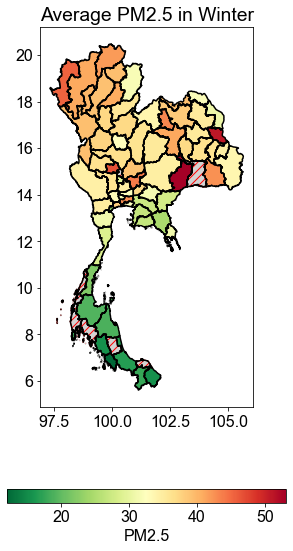

In [7]:
_, ax = plt.subplots(1, 1, figsize=(5,10))
plot_map.plot(column='PM2.5',
           ax=ax,legend=True,
           legend_kwds={'label': "PM2.5",
                       'orientation': "horizontal"},  cmap='RdYlGn_r',
             missing_kwds={
         "color": "lightgrey",
         "edgecolor": "red",
            "hatch": "///",
           "label": "Missing values" },)

 
plot_map.boundary.plot(ax=ax, color='black')

ax.set_title("Average PM2.5 in Winter")
plt.savefig(mdataset.report_folder + 'avg_pm25_map.png', dpi=300)

In [87]:
plt_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
print(len(plt_colors))

10


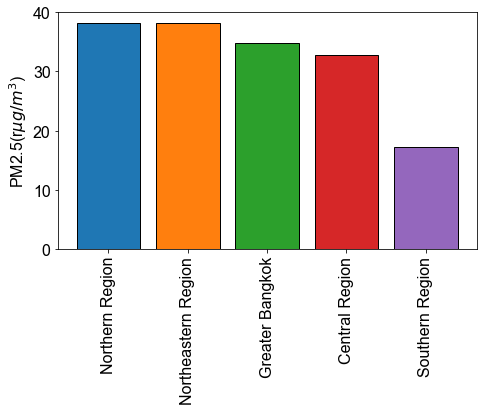

In [98]:
pm25_region_avg = plot_map.groupby('region').mean()['PM2.5']
pm25_region_avg = pm25_region_avg.sort_values(ascending=False)
fig, ax = plt.subplots(1,1, figsize=(7, 6))
plt.bar(pm25_region_avg.index, pm25_region_avg.values, color=plt_colors, edgecolor='black')
plt.draw()
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
plt.ylabel('PM2.5(r$\mu g/m^3$)')
plt.tight_layout()
plt.savefig(mdataset.report_folder + 'pm25_region.png', dpi=300)

# Near Income Province

In [8]:
# select province based on average income level
# load income data by province 
income = pd.read_csv(mdataset.health_folder + 'process/income_98_19.csv')
income = income.drop('thaiprov', axis=1).set_index('province')
income.columns = income.columns.astype(int)
income.head()

,1998,2000,2002,2004,2006,2007,2009,2011,2013,2015,2017,2019
province,,,,,,,,,,,,
Whole Kingdom,12492.0,12150.0,13736.0,14963.0,17787.0,18660.0,20904.0,23235.9,25194.0,26914.846584,26946.43,26018.42
Greater Bangkok,24929.0,25242.0,28239.0,28135.0,33088.0,35007.0,37732.0,41630.6,43058.0,41002.390519,NaN,NaN
Bangkok,26054.0,26909.0,29589.0,29843.0,36658.0,39020.0,42380.0,48951.0,49190.8,45571.700000,45707.31,39459.36
Samut Prakan,18100.0,15745.0,19680.0,19946.0,20382.0,21302.0,23359.0,23797.9,29575.3,25457.200000,28711.77,24729.42
Nonthaburi,24211.0,24566.0,29119.0,26658.0,31152.0,32743.0,34626.0,35119.7,30663.6,36884.000000,40860.88,37502.22


In [62]:
# select province based on average income level
avg_income = income.mean(axis=1).astype(int).sort_values()

18038.14457831325
16716.0
5094.773575314241
14522


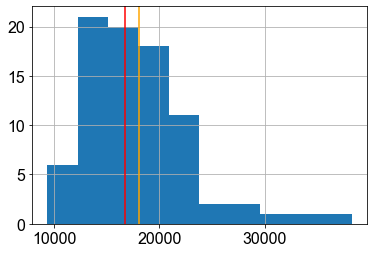

In [66]:
avg_income.hist()
plt.axvline(avg_income.median(), color='red')
plt.axvline(avg_income.mean(), color='orange')
print(avg_income.mean())
print(avg_income.median())
print(avg_income.std())
print(avg_income.loc['Chiang Mai'])

In [71]:
# select province based on average income level
#avg_income = income.mean(axis=1).astype(int).sort_values()
cm_income = avg_income.median()
print(cm_income)
near_income = avg_income[(avg_income < cm_income + 2500) & (avg_income > cm_income - 2500) ]
#near_income = near_income.drop(['Northeastern Region', 'Northern Region'])
near_income_list = near_income.index.to_list()
to_drop = [s for s in near_income_list if 'Region' in s]
near_income = near_income.drop(to_drop)

near_income.index.to_list()

16716.0


['Chaiyaphum',
 'Chiang Mai',
 'Pattani',
 'Uthai Thani',
 'Loei',
 'Phrae',
 'Phetchabun',
 'Mukdahan',
 'Nong Khai',
 'Yala',
 'Uttaradit',
 'Suphan Buri',
 'Khon Kaen',
 'Sukhothai',
 'Sa Kaeo',
 'Lampang',
 'Phitsanulok',
 'Maha Sarakham',
 'Ubon Ratchathani',
 'Phichit',
 'Nakhon Sawan',
 'Kanchanaburi',
 'Kamphaeng Phet',
 'Udon Thani',
 'Nakhon Ratchasima',
 'Lamphun',
 'Satun',
 'Lop Buri',
 'Nakhon Nayok',
 'Samut Songkhram',
 'Chai Nat',
 'Phattalung',
 'Prachuap Khiri Khan',
 'Prachin Buri',
 'Trat',
 'Phetchaburi']

In [72]:
near_income_list = ['Chaiyaphum',
 'Chiang Mai',
 'Pattani',
 'Uthai Thani',
 'Loei',
 'Phrae',
 'Phetchabun',
 'Mukdahan',
 'Nong Khai',
 'Yala',
 'Uttaradit',
 'Suphan Buri',
 'Khon Kaen',
 'Sukhothai',
 'Sa Kaeo',
 'Lampang',
 'Phitsanulok',
 'Maha Sarakham',
 'Ubon Ratchathani',
 'Phichit',
 'Nakhon Sawan',
 'Kanchanaburi',
 'Kamphaeng Phet',
 'Udon Thani',
 'Nakhon Ratchasima',
 'Lamphun',
 'Satun',
 'Lop Buri',
 'Nakhon Nayok',
 'Samut Songkhram',
 'Chai Nat',
 'Phattalung',
 'Prachuap Khiri Khan',
 'Prachin Buri',
 'Trat',
 'Phetchaburi']

In [73]:
provinces = mdataset.prov_map[['region', 'province']]

region_list = ['Northern Region', 'Northeastern Region', 'Central Region','Greater Bangkok','Southern Region']

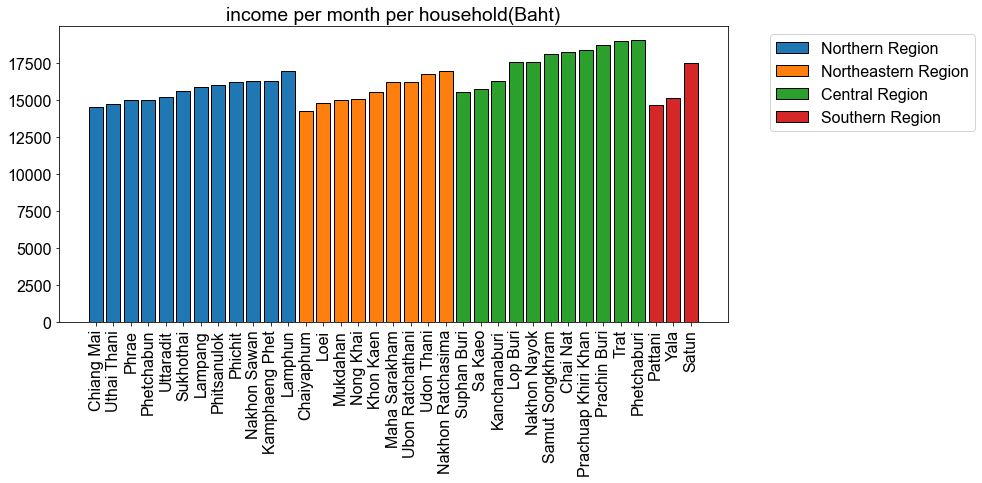

In [74]:
fig, ax = plt.subplots(1,1, figsize=(14, 7))

province_list = []
for region in region_list:
    # select province
    prov_in_region = provinces[provinces['region'] == region]['province'].to_list()
    df = near_income[near_income.index.isin(prov_in_region)]
    province_list += df.index.to_list()
    if len(df) > 0:
        ax.bar(df.index, df, label=region, edgecolor='black')
 
#df = near_income.loc[['Chiang Mai']]
#ax.bar(df.index, df, color='magenta', label='Chiang Mai', edgecolor='black')

ax.legend(bbox_to_anchor=(1.05, 1.0))
plt.draw()
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

#ax.set_xlabel('province')
ax.set_title('income per month per household(Baht)')
plt.tight_layout()
plt.savefig(mdataset.report_folder + 'income_bar.png', dpi=300)

plotting pollution bar

In [75]:
# use province_list to keep the bar plot in the same order
pm25_short = pd.DataFrame(index=province_list, columns =['PM2.5'])
pm25_short = pm25_short.merge(mean_poll, right_index=True, left_index=True, how='left', suffixes=('_x', ''))
pm25_short = pm25_short[['PM2.5']]

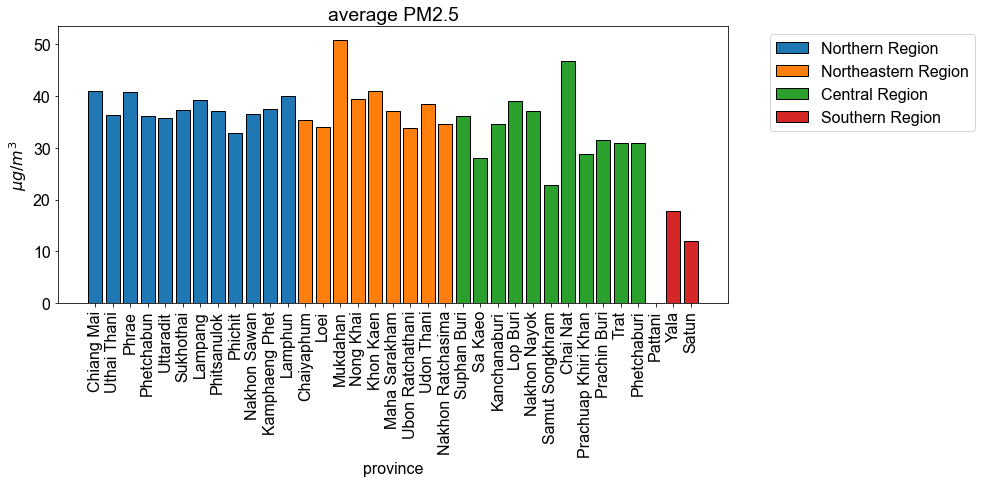

In [76]:
fig, ax = plt.subplots(1,1, figsize=(14, 7))
#ax.bar(pm10_short_list['province'], pm10_short_list['avgPM10'])

for region in region_list:
    # select province
    prov_in_region = provinces[provinces['region'] == region]['province'].to_list()
    # select only province near Chiang Mai
    # use province_list to keep the bar plot in the same order

    prov_in_region = [s for s in province_list if s in prov_in_region]
    df = pm25_short.loc[prov_in_region]
     
    if len(df) > 0:
        ax.bar(df.index, df['PM2.5'], label=region, edgecolor='black')
# highlight Chiang Mai
#df = pm25_short.loc[['Chiang Mai']]
#ax.bar(df.index, df['PM2.5'], color='magenta', label='Chiang Mai', edgecolor='black')

ax.set_xlabel('province')
ax.set_ylabel('$\mu g/m^3$')
ax.legend(bbox_to_anchor=(1.05, 1.0))
plt.draw()
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
ax.set_title('average PM2.5')
plt.tight_layout()
plt.savefig(mdataset.report_folder + 'avg_pm25_bar.png', dpi=300)

# Smoking Rate

In [76]:
smoke = pd.read_csv(mdataset.health_folder  + 'process/smoke.csv')

# remove strange year 
smoke = smoke[~smoke['year'].isin([2001, 2014])]
smoke = smoke.set_index(['region', 'gender', 'year'])

# calculate the rate 
smoke['total'] = smoke.sum(axis=1)
smoke['freq_rate'] = smoke['frequent']/smoke['total']

smoke.head()

frequent         never    occasional  \
region              gender year                                             
Central Region      Female 2004  4.140495e+06  2.405032e+07  8.416739e+05   
                    Male   2004  1.860313e+06  2.980548e+06  3.820262e+05   
Greater Bangkok     Female 2004  8.991480e+05  8.884521e+06  1.594606e+05   
                    Male   2004  8.176897e+05  1.950692e+06  1.476288e+05   
Northeastern Region Female 2004  7.080440e+06  3.089837e+07  1.039622e+06   

                                      unknown  former frequent  \
region              gender year                                  
Central Region      Female 2004  2.408923e+06     7.628249e+05   
                    Male   2004  0.000000e+00     3.528641e+05   
Greater Bangkok     Female 2004  0.000000e+00     2.081420e+05   
                    Male   2004  0.000000e+00     1.695960e+05   
Northeastern Region Female 2004  4.236681e+06     1.466386e+06   

                                 former occasional         total  freq_rate  
region              gender year                                              
Central Region      Female 2004        366651.9865  3.257089e+07   0.127123  
                    Male   2004        158922.0095  5.734674e+06   0.324397  
Greater Bangkok     Female 2004         72811.8139  1.022408e+07   0.087944  
                    Male   2004         59242.9813  3.144850e+06   0.260009  
Northeastern Region Female 2004        654328.3634  4.537583e+07   0.156040

In [77]:
smoke = smoke.reset_index()

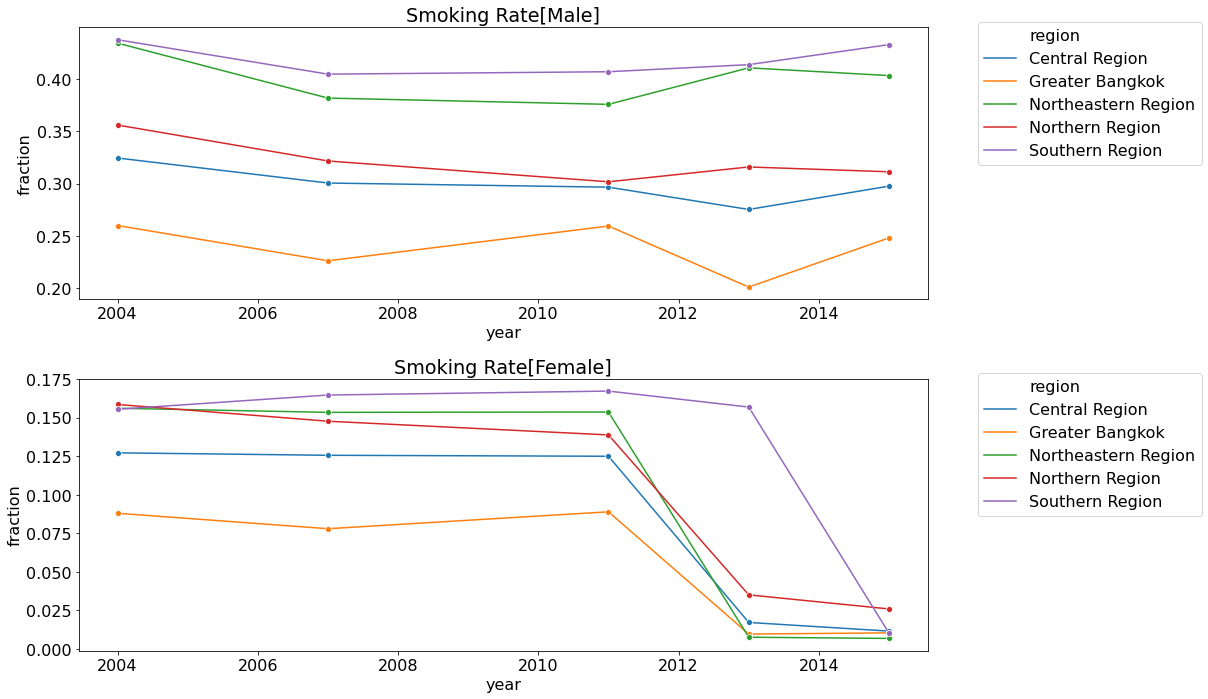

In [79]:
_, ax = plt.subplots(2,1, figsize=(17,10))
temp = smoke[smoke['gender'] == 'Male']
sns.lineplot(data=temp, x='year', y='freq_rate', hue='region', marker='o', ax=ax[0], ci=None)


temp = smoke[smoke['gender'] == 'Female']
sns.lineplot(data=temp, x='year', y='freq_rate', hue='region', marker='o', ax=ax[1], ci=None)

title_list = ['Smoking Rate[Male]', 'Smoking Rate[Female]']
for a, t in zip(ax, title_list) :
    a.legend(bbox_to_anchor=(1.05,1.05))
    a.set_title(t)
    a.set_ylabel('fraction')
    
plt.tight_layout()
plt.savefig(mdataset.report_folder+'smoke_year.png', dpi=300)

In [69]:
smoke[smoke['year']==2015]

,region,gender,year,frequent,never,occasional,unknown,former frequent,former occasional,total,freq_rate
40,Central Region,Male,2015,2.336758e+06,3.704222e+06,476429.6740,96902.7885,616339.6889,622453.2304,7.853105e+06,0.297558
41,Central Region,FeMale,2015,9.602598e+04,8.040108e+06,41166.1280,42902.1536,41586.5199,54444.5180,8.316233e+06,0.011547
42,Greater Bangkok,Male,2015,8.919991e+05,1.955539e+06,177747.2772,38861.2314,260938.4006,268850.5359,3.593936e+06,0.248196
43,Greater Bangkok,FeMale,2015,4.041865e+04,3.739877e+06,57360.7673,7543.0941,15906.6824,20308.1158,3.881414e+06,0.010413
44,Northeastern Region,Male,2015,2.878510e+06,2.366721e+06,343737.4778,40537.6522,938413.3564,574529.5111,7.142449e+06,0.403014
45,Northeastern Region,FeMale,2015,5.233274e+04,7.534318e+06,15640.2525,6043.6992,60268.3094,37401.5933,7.706005e+06,0.006791
46,Northern Region,Male,2015,1.423963e+06,1.934414e+06,181323.3478,26724.6178,659159.2689,349601.0157,4.575185e+06,0.311236
47,Northern Region,FeMale,2015,1.270283e+05,4.583260e+06,26896.1184,5983.5629,105522.6676,54230.3613,4.902921e+06,0.025909
48,Southern Region,Male,2015,1.516676e+06,1.222867e+06,217999.0255,29549.7067,322135.7550,197198.5330,3.506426e+06,0.432542
49,Southern Region,FeMale,2015,3.745877e+04,3.585283e+06,7566.0831,10291.3994,24327.8462,15617.1982,3.680544e+06,0.010178


# Search for causes of dead with has regional differences

In [196]:
near_income_list = ['Chaiyaphum',
 'Chiang Mai',
 'Pattani',
 'Uthai Thani',
 'Loei',
 'Phrae',
 'Phetchabun',
 'Mukdahan',
 'Nong Khai',
 'Yala',
 'Uttaradit',
 'Suphan Buri',
 'Khon Kaen',
 'Sukhothai',
 'Sa Kaeo',
 'Lampang',
 'Phitsanulok',
 'Maha Sarakham',
 'Ubon Ratchathani',
 'Phichit',
 'Nakhon Sawan',
 'Kanchanaburi',
 'Kamphaeng Phet',
 'Udon Thani',
 'Nakhon Ratchasima',
 'Lamphun',
 'Satun',
 'Lop Buri',
 'Nakhon Nayok',
 'Samut Songkhram',
 'Chai Nat',
 'Phattalung',
 'Prachuap Khiri Khan',
 'Prachin Buri',
 'Trat',
 'Phetchaburi']

In [197]:
# loading the data 
population = pd.read_csv(mdataset.health_folder  + 'process/pop_prov.csv')  
population = population.drop(['province_th', 'gender_th'], axis=1)

pop = population.melt(id_vars=['province', 'gender'], var_name='year', value_name='pop')
pop['year'] = pop['year'].astype(int)
dead = pd.read_csv(mdataset.health_folder + 'process/cause_of_dead.csv').dropna()
# add population 
dead = dead.merge(pop, on=['province', 'gender', 'year'], how='left')

# add birth rate

birth_rate = pd.read_csv(mdataset.health_folder  + 'process/birth_prov.csv')
birth_rate = birth_rate.rename(columns={'number':'birth_number'})
birth_rate['year'] = birth_rate['year'].astype(int)


dead = dead.merge(birth_rate, on=['province',  'year'], how='left')

# load provinces & region information 
provinces = mdataset.prov_map[['region', 'province']]

region_list = ['Northern Region', 'Northeastern Region', 'Central Region', 'Greater Bangkok', 'Southern Region']

# add region
dead = dead.merge(provinces, on='province', how='left')

In [101]:
dead.head()

,year,gender,cause_of_dead,number,admin1Name_th,province,pop,birth_number,region
0,2009,Male,อาการท้องร่วง กระเพาะและลำไส้อักเสบจากการติดเชื้อ,22,กรุงเทพมหานคร,Bangkok,2713535.0,101112,Greater Bangkok
1,2009,Male,วัณโรคทางเดินหายใจ,261,กรุงเทพมหานคร,Bangkok,2713535.0,101112,Greater Bangkok
2,2009,Male,วัณโรคอื่น ๆ,20,กรุงเทพมหานคร,Bangkok,2713535.0,101112,Greater Bangkok
3,2009,Male,บาดทะยัก,2,กรุงเทพมหานคร,Bangkok,2713535.0,101112,Greater Bangkok
4,2009,Male,โลหิตเป็นพิษ,1495,กรุงเทพมหานคร,Bangkok,2713535.0,101112,Greater Bangkok


In [102]:
cause = dead['cause_of_dead'].drop_duplicates().reset_index(drop=True)
birth_defect = cause[cause.str.contains('ครรภ์') | cause.str.contains('กำเนิด')| cause.str.contains('แรกเกิด')| cause.str.contains('แท้ง')| cause.str.contains('ทารก')].to_list()
birth_defect

['ทารกในครรภ์แรกเกิดที่ได้รับผลจากปัจจัยทางมารดาและโรคแทรกในระยะตั้งครรภ์ เจ็บครรภ์และคลอด',
 'ความผิดปกติเกี่ยวกับการตั้งครรภ์และการเจริญเติบโตของทารกในครรภ์',
 'การขาดอ็อกซิเจนขณะอยู่ในโพรงมดลูกและภาวะแอสฟิกเซียเมื่อแรกเกิด',
 'ปอดบวมแต่กำเนิด',
 'ภาวะการหายใจอื่น ๆ ในทารกแรกเกิด',
 'การติดเชื้อและมีพิษของแบคทีเรียในกระแสเลือดในทารกแรกเกิด',
 'ภาวะปริกำเนิดอื่น ๆ',
 'ศีรษะรูปบาตรและกระดูกสันหลังแยกแต่กำเนิด',
 'ความผิดปกติแต่กำเนิดของระบบประสาทอื่น ๆ',
 'ความผิดปกติของหัวใจแต่กำเนิด',
 'ความผิดปกติอื่น ๆ แต่กำเนิด',
 'การแท้ง',
 'โรคแทรกของการเจ็บครรภ์และการคลอด',
 'ภาวะหายใจลำบากของทารกแรกเกิด',
 'เลือดออกและความผิดปกติเกี่ยวกับเลือดของทารกในครรภ์และแรกเกิด',
 'ความผิดปกติแต่กำเนิดของระบบไหลเวียนโลหิตอื่น ๆ',
 'การตั้งครรภ์ การคลอดและระยะหลังคลอดอื่น ๆ',
 'ความผิดปกติอื่นที่ส่วนใหญ่เป็นผลจากการตั้งครรภ์',
 'สะดืออักเสบในทารกแรกเกิดชนิดมีหรือไม่มีเลือดออก']

## Compare Regions

In [109]:
region_to_compare = ['Northern Region', 'Northeastern Region', 'Central Region', 'Southern Region']

# pick only three regions
dead_3reg = dead[dead['region'].isin(region_to_compare)]

# calculate the rate by cause_of_dead by year, gender, region
dead_3reg = dead_3reg.groupby(['year', 'gender', 'cause_of_dead', 'region' ]).sum()

# calcule rate
dead_3reg['rate'] = dead_3reg['number']/dead_3reg['pop']

dead_3reg = dead_3reg.reset_index()
dead_3reg.head()

,year,gender,cause_of_dead,region,number,pop,birth_number,rate
0,2009,Female,กลุ่มอาการและความผิดปกติของโครโมโซม,Central Region,16,3169695.0,89324,0.000005
1,2009,Female,กลุ่มอาการและความผิดปกติของโครโมโซม,Northeastern Region,7,3242314.0,66139,0.000002
2,2009,Female,กลุ่มอาการและความผิดปกติของโครโมโซม,Northern Region,7,1691894.0,36611,0.000004
3,2009,Female,กลุ่มอาการและความผิดปกติของโครโมโซม,Southern Region,7,1732192.0,55647,0.000004
4,2009,Female,การขาดอ็อกซิเจนขณะอยู่ในโพรงมดลูกและภาวะแอสฟิก...,Central Region,24,4925269.0,133035,0.000005


In [110]:
significant_df1 = []
for year, gender, cause in zip(dead_3reg['year'], dead_3reg['gender'], dead_3reg['cause_of_dead']):
    temp = dead_3reg[(dead_3reg['year']==year) & (dead_3reg['gender']==gender) & (dead_3reg['cause_of_dead']==cause )]
    temp = temp.set_index('region')
    if len(temp) == 4:
        row_ne = temp.loc['Northeastern Region']
        row_s = temp.loc['Southern Region']
        z1 = cal_1z_test(row_ne, row_s) 
        
        row_n = temp.loc['Northern Region']
        
        z2 = cal_1z_test(row_n, row_s) 
        
        row_c = temp.loc['Central Region']
      
        z3 = cal_1z_test(row_c, row_s) 
        
        #if (z1 >= 1.96) & (z2>= 1.96) & (z3>= 1.96):
        significant_df1.append([year, gender, cause, z1, z2, z3, row_n['rate']/row_s['rate'], row_ne['rate']/row_s['rate'], row_c['rate']/row_s['rate']] )
        
significant_df1 = pd.DataFrame(significant_df1, columns=['year', 'gender', 'cause', 'z_NE', 'z_N', 'z_C', 'ratio_north_south', 'ratio_northeast_south',  'ratio_central_south'])
 
# z2 should be more than z1
#significant_df['north_higher_than_ne_c'] =  (significant_df['z_N'] > significant_df['z_NE']) & (significant_df['z_N'] > significant_df['z_C']) 

#significant_df = significant_df[significant_df['north_higher_than_ne_c'] == True]

significant_df1 = significant_df1.drop_duplicates()

In [111]:
remove_list =  [ 'การติดเชื้อเอชไอวี/เอดส์', 'การพลัดตก หกล้ม', 'ภาวะทุพโภชนาการ',  'ฆ่าตัวตาย', 'โลหิตจาง', 'อุบัติเหตุจากการขนส่งทางบก',
       'อาการท้องร่วง กระเพาะและลำไส้อักเสบจากการติดเชื้อ', 'แผลกระเพาะอาหารและดูโอเดนั่ม', 'อาการแสดงที่พบจากการตรวจทางห้องปฏิบัติการ',
       'โรคของตับ',  
       'โรคติดเชื้อและปรสิตอื่น ๆ', 'โรคมะเร็งกระเพาะอาหาร',
       'โรคมะเร็งตับ',  'โรคระบบย่อยอาหารอื่น ๆ',
       'ความผิดปกติทางจิตเนื่องจากการใช้วัตถุออกฤทธิ์ต่อจิตประสาท',
       'สาเหตุจากภายนอกอื่น ๆ', 'อุบัติเหตุการตกน้ำจมน้ำ', 'โรคต่อมไร้ท่อ โภชนาการและเมตะบอสลิซึมอื่น ๆ']

significant_df1 = significant_df1[~significant_df1['cause'].isin(remove_list)]

In [113]:
significant_df1.shape

(1376, 9)

In [114]:
significant_df1['cause'].unique()

array(['กลุ่มอาการและความผิดปกติของโครโมโซม',
       'การขาดอ็อกซิเจนขณะอยู่ในโพรงมดลูกและภาวะแอสฟิกเซียเมื่อแรกเกิด',
       'การติดเชื้อและมีพิษของแบคทีเรียในกระแสเลือดในทารกแรกเกิด',
       'การสัมผัสควัน ไฟและเปลวไฟ',
       'การเป็นพิษโดยอุบัติเหตุจากการสัมผัสกับสารเป็นพิษ', 'การแท้ง',
       'ความดันโลหิตสูง', 'ความผิดปกติของหัวใจแต่กำเนิด',
       'ความผิดปกติอื่น ๆ แต่กำเนิด',
       'ความผิดปกติเกี่ยวกับการตั้งครรภ์และการเจริญเติบโตของทารกในครรภ์',
       'ความผิดปกติแต่กำเนิดของระบบประสาทอื่น ๆ', 'ถูกทำร้าย', 'บาดทะยัก',
       'ปอดบวม', 'ปอดบวมแต่กำเนิด', 'ภาวะการหายใจอื่น ๆ ในทารกแรกเกิด',
       'ภาวะปริกำเนิดอื่น ๆ', 'มะเร็งต่อมน้ำเหลืองไม่ใช่ฮอดกินส์',
       'มะเร็งอื่น ๆ', 'มาลาเรีย', 'วัณโรคทางเดินหายใจ', 'วัณโรคอื่น ๆ',
       'ศีรษะรูปบาตรและกระดูกสันหลังแยกแต่กำเนิด', 'เนื้องอก',
       'เยื้อหุ้มสมองอักเสบ', 'โรคของทางเดินหายใจส่วนล่างเรื้อรัง',
       'โรคของผิวหนังและเนื้อเยื่อใต้ผิวหนัง',
       'โรคของระบบกล้ามเนื้อกระดูก', 'โรคของระบบทางเดินหายใจอื่น ๆ',
    

## Compare provinces with similar income

In [115]:
region_to_compare = ['Northern Region', 'Northeastern Region', 'Southern Region', 'Central Region']

# pick only three regions
dead_3reg = dead[dead['region'].isin(region_to_compare) & dead['province'].isin(near_income_list)]

# calculate the rate by cause_of_dead by year, gender, region
dead_3reg = dead_3reg.groupby(['year', 'gender', 'cause_of_dead', 'region' ], as_index=False).sum()

# calcule rate
dead_3reg['rate'] = dead_3reg['number']/dead_3reg['pop']

dead_3reg = dead_3reg.reset_index()

In [116]:
significant_df2 = []
for year, gender, cause in zip(dead_3reg['year'], dead_3reg['gender'], dead_3reg['cause_of_dead']):
    temp = dead_3reg[(dead_3reg['year']== year ) & (dead_3reg['gender']==gender) & (dead_3reg['cause_of_dead']==cause )]
    temp = temp.set_index('region')
    if len(temp) == 4:
        row_ne = temp.loc['Northeastern Region']
        row_s = temp.loc['Southern Region']
        z1 = cal_1z_test(row_ne, row_s) 
        
        row_n = temp.loc['Northern Region']
        
        z2 = cal_1z_test(row_n, row_s) 
        
        row_c = temp.loc['Central Region']
      
        z3 = cal_1z_test(row_c, row_s) 
        
        #if (z1 >= 1.96) & (z2>= 1.96) & (z3>= 1.96):
        significant_df2.append([year, gender, cause, z1, z2, z3 ] )
        
significant_df2 = pd.DataFrame(significant_df2, columns=['year', 'gender', 'cause', 'z_NE_income', 'z_N_income', 'z_C_income' ])

significant_df2 = significant_df2.drop_duplicates()

In [117]:
remove_list = [ 'การติดเชื้อเอชไอวี/เอดส์', 'การพลัดตก หกล้ม', 'ภาวะทุพโภชนาการ',  'ฆ่าตัวตาย', 'โลหิตจาง', 'อุบัติเหตุจากการขนส่งทางบก',
       'อาการท้องร่วง กระเพาะและลำไส้อักเสบจากการติดเชื้อ', 'แผลกระเพาะอาหารและดูโอเดนั่ม', 'อาการแสดงที่พบจากการตรวจทางห้องปฏิบัติการ',
       'โรคของตับ',  
       'โรคติดเชื้อและปรสิตอื่น ๆ', 'โรคมะเร็งกระเพาะอาหาร',
       'โรคมะเร็งตับ',  'โรคระบบย่อยอาหารอื่น ๆ',
       'ความผิดปกติทางจิตเนื่องจากการใช้วัตถุออกฤทธิ์ต่อจิตประสาท',
       'สาเหตุจากภายนอกอื่น ๆ', 'อุบัติเหตุการตกน้ำจมน้ำ', 'โรคต่อมไร้ท่อ โภชนาการและเมตะบอสลิซึมอื่น ๆ']

significant_df2 = significant_df2[~significant_df2['cause'].isin(remove_list)]

In [118]:
significant_df_merge = significant_df1.merge(significant_df2, on=['year', 'gender', 'cause'], how='inner')
significant_df_merge.shape

(1158, 12)

In [119]:
significant_df_merge.to_csv(mdataset.health_folder  + 'process/' + 'cause_of_dead_narrow.csv', index=False, encoding='utf-8')

In [125]:
dead_signi_merge = pd.read_csv(mdataset.health_folder  + 'process/' + 'cause_of_dead_narrow.csv')

In [126]:
dead_signi_merge_avg = dead_signi_merge.groupby(['gender', 'cause'], as_index=False).mean()

In [130]:
# filter for high z for all regions
dead_narrow = dead_signi_merge_avg[(dead_signi_merge_avg['z_N']> 1.96 ) & (dead_signi_merge_avg['z_NE']> 1.96 )] 
dead_narrow['cause'].unique()

array(['ปอดบวม', 'มะเร็งอื่น ๆ', 'วัณโรคทางเดินหายใจ',
       'เยื้อหุ้มสมองอักเสบ', 'โรคของระบบกล้ามเนื้อกระดูก',
       'โรคของระบบสืบพันธุ์และทางเดินปัสสาวะอื่น ๆ',
       'โรคมะเร็งหลอดลมและปอด', 'โลหิตเป็นพิษ',
       'โรคของผิวหนังและเนื้อเยื่อใต้ผิวหนัง'], dtype=object)

In [136]:
dead_narrow[dead_narrow['cause'].isin(['ปอดบวม', 'วัณโรคทางเดินหายใจ', 'โรคมะเร็งหลอดลมและปอด'])].sort_values(['z_N', 'z_NE', 'z_C'], ascending=False).round(2)

,gender,cause,year,z_NE,z_N,z_C,ratio_north_south,ratio_northeast_south,ratio_central_south,z_NE_income,z_N_income,z_C_income
83,Male,ปอดบวม,2014.0,10.89,16.80,19.39,1.79,1.41,1.95,9.36,11.63,12.11
50,Female,โรคมะเร็งหลอดลมและปอด,2014.0,3.01,14.78,6.33,2.38,1.21,1.50,4.07,7.88,5.04
114,Male,โรคมะเร็งหลอดลมและปอด,2014.0,2.78,14.31,7.27,1.82,1.13,1.38,6.43,10.36,7.51
17,Female,ปอดบวม,2014.0,8.69,13.30,19.10,1.75,1.40,2.16,7.30,9.15,11.00
92,Male,วัณโรคทางเดินหายใจ,2014.0,5.78,5.11,5.94,1.38,1.40,1.45,0.96,2.11,2.23
26,Female,วัณโรคทางเดินหายใจ,2014.0,6.46,4.31,4.52,1.61,1.89,1.63,1.17,1.37,1.75


In [253]:
dead_signi_merge_avg[(dead_signi_merge_avg['z_N']> 1.96 ) & (dead_signi_merge_avg['z_NE']> 1.96 )].sort_values(['cause', 'gender'])

,gender,cause,year,z_NE,z_N,z_C,ratio_north_south,ratio_northeast_south,ratio_central_south,z_NE_income,z_N_income,z_C_income
15,Female,ปอดบวม,2014.0,8.687474,13.295297,19.096438,1.745149,1.395490,2.155915,5.418226,8.353958,9.372265
79,Male,ปอดบวม,2014.0,10.890973,16.798368,19.393277,1.790499,1.412297,1.948360,7.356104,11.038642,10.579121
22,Female,มะเร็งอื่น ๆ,2014.0,12.606739,9.074229,5.533128,1.515615,1.686081,1.296353,9.307375,7.469516,4.364729
85,Male,มะเร็งอื่น ๆ,2014.0,14.729482,9.849550,5.608092,1.477625,1.685745,1.256664,12.368059,9.583182,5.516365
24,Female,วัณโรคทางเดินหายใจ,2014.0,6.461618,4.309627,4.520803,1.614653,1.885024,1.626180,1.728663,-0.245972,0.834598
87,Male,วัณโรคทางเดินหายใจ,2014.0,5.776189,5.112815,5.942176,1.383895,1.395860,1.445042,0.172721,-1.016400,0.520179
28,Female,เยื้อหุ้มสมองอักเสบ,2014.4,2.094671,2.966699,1.712863,2.345005,1.819780,1.667725,0.669720,1.035050,0.368563
91,Male,เยื้อหุ้มสมองอักเสบ,2014.0,3.182292,4.734570,3.101427,2.813571,2.028876,2.111741,1.358596,1.913171,0.641446
94,Male,โรคของผิวหนังและเนื้อเยื่อใต้ผิวหนัง,2014.0,2.091938,6.110489,5.668450,2.157557,1.306752,2.065563,1.731167,3.347171,2.891153
32,Female,โรคของระบบกล้ามเนื้อกระดูก,2014.0,5.930703,5.617710,3.151932,2.011366,2.058547,1.492773,3.122885,3.133634,1.975141


## Visualization

In [227]:
## to do, plot the weighted error bar 
from statsmodels.stats.weightstats import DescrStatsW

array = np.array([1,2,1,2,1,2,1,3])
weights = np.ones_like(array)
weights[3] = 100
weighted_stats = DescrStatsW(array, weights=weights, ddof=0)
weighted_stats.std    

0.21434289609681711

In [240]:
dis = 'โรคมะเร็งหลอดลมและปอด'

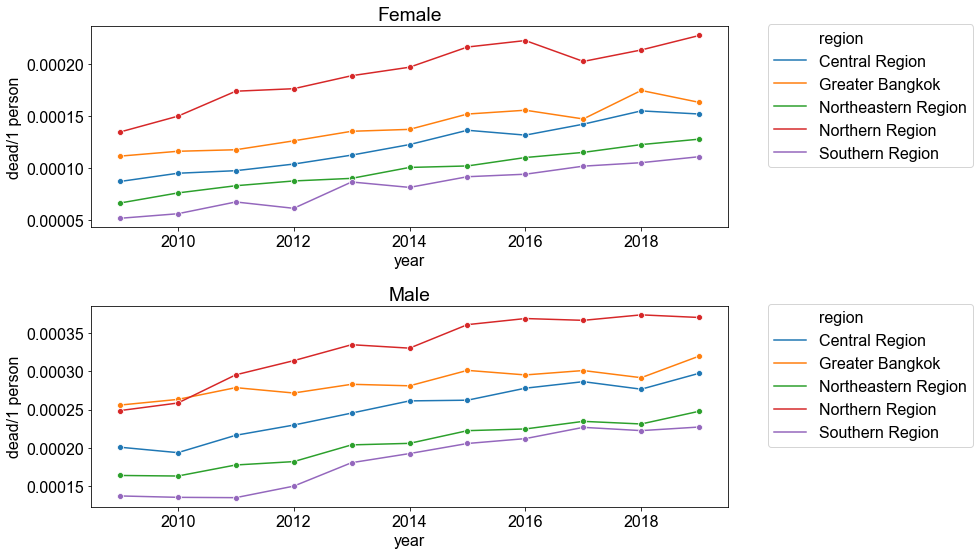

In [235]:
# calculate the rate by cause_of_dead by year, gender, region
dead_reg = dead.groupby(['year', 'gender', 'cause_of_dead', 'region' ]).sum()

# calcule rate
dead_reg['rate'] = dead_reg['number']/dead_reg['pop']

# reset index
dead_reg = dead_reg.reset_index()

one_disease = dead_reg[dead_reg['cause_of_dead'] == dis]

# plotting 
_, ax = plt.subplots(2,1, figsize=(14,8))

df = one_disease[one_disease['gender']=='Female']
sns.lineplot(data=df, x='year', y='rate', hue='region', ax=ax[0], marker='o')

df = one_disease[one_disease['gender']=='Male']
sns.lineplot(data=df, x='year', y='rate', hue='region', ax=ax[1], marker='o')

for a, t in zip(ax, ['Female', 'Male']):
    a.set_title(t)
    a.legend(bbox_to_anchor=(1.05, 1.05))
    a.set_ylabel('dead/1 person')
    
plt.tight_layout()
plt.savefig(mdataset.report_folder + 'dead_lung_over_years.png', dpi=300)

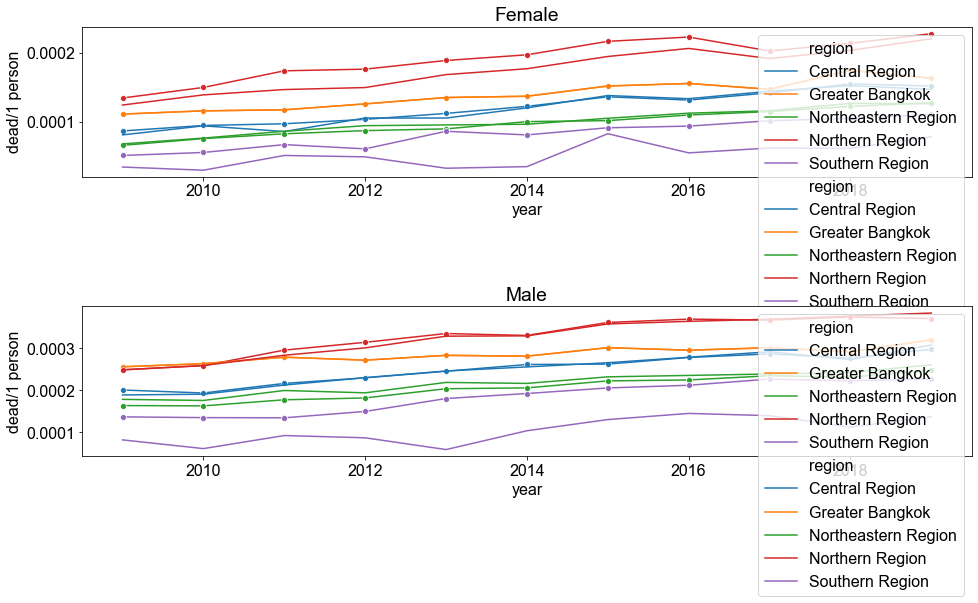

In [225]:
# calculate the rate by cause_of_dead by year, gender, region
dead_reg = dead.groupby(['year', 'gender', 'cause_of_dead', 'region' ]).sum()

# calcule rate
dead_reg['rate'] = dead_reg['number']/dead_reg['pop']

# reset index
dead_reg = dead_reg.reset_index()

one_disease = dead_reg[dead_reg['cause_of_dead'] == dis]

# plotting 
_, ax = plt.subplots(2,1, figsize=(14,8))

df = one_disease[one_disease['gender']=='Female']
sns.lineplot(data=df, x='year', y='rate', hue='region', ax=ax[0], marker='o')

df = one_disease[one_disease['gender']=='Male']
sns.lineplot(data=df, x='year', y='rate', hue='region', ax=ax[1], marker='o')

for a, t in zip(ax, ['Female', 'Male']):
    a.set_title(t)
    a.legend(bbox_to_anchor=(1.05, 1.05))
    a.set_ylabel('dead/1 person')
    
# narrow to near income provinces
# calculate the rate by cause_of_dead by year, gender, region
dead_reg = dead[dead['province'].isin(near_income_list + ['Bangkok', 'Samut Prakan', 'Nonthaburi', 'Pathum Thani'])]
dead_reg = dead_reg.groupby(['year', 'gender', 'cause_of_dead', 'region' ]).sum()

# calcule rate
dead_reg['rate'] = dead_reg['number']/dead_reg['pop']

# reset index
dead_reg = dead_reg.reset_index()

one_disease = dead_reg[dead_reg['cause_of_dead'] == dis]

df = one_disease[one_disease['gender']=='Female']
sns.lineplot(data=df, x='year', y='rate', hue='region', ax=ax[0],  dashes=[(4,4)])

df = one_disease[one_disease['gender']=='Male']
sns.lineplot(data=df, x='year', y='rate', hue='region', ax=ax[1],  dashes=[(4,4)])

for a, t in zip(ax, ['Female', 'Male']):
    a.set_title(t)
    a.legend(bbox_to_anchor=(1.05, 1.05))
    a.set_ylabel('dead/1 person')

    
plt.tight_layout()

In [242]:
# select year 
temp = dead[dead['year'].isin(np.arange(2015, 2020))]
mean_rate = temp.groupby(['year', 'gender', 'cause_of_dead', 'province' ]).sum()

# calcule rate
mean_rate['rate'] = mean_rate['number']/mean_rate['pop']*100000

# reset index
mean_rate = mean_rate.reset_index()
mean_rate = mean_rate[mean_rate['cause_of_dead'] == dis]

# average of the rate
std_rate = mean_rate.groupby([ 'gender', 'cause_of_dead', 'province'], as_index=False).std()

mean_rate = mean_rate.groupby([ 'gender', 'cause_of_dead', 'province'], as_index=False).mean()

mean_rate = mean_rate.merge(std_rate, on=[ 'gender', 'cause_of_dead', 'province'], suffixes=('', '_std'))

# create a map of pollution by merging with the shape file 
plot_map = mdataset.prov_map.merge(mean_rate, on='province', how='left')

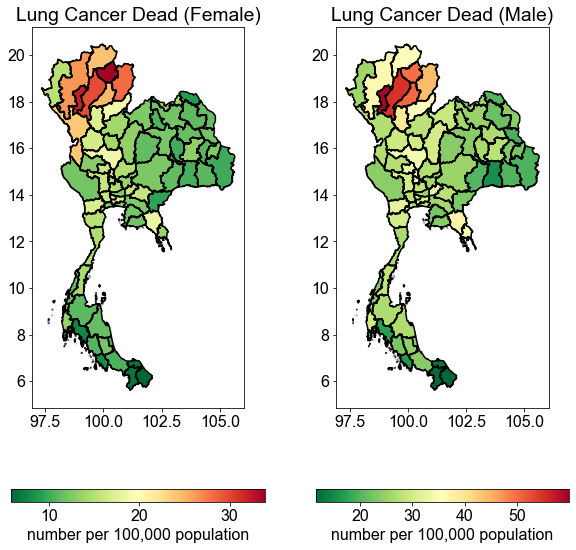

In [244]:
_, ax = plt.subplots(1, 2, figsize=(10,10))

df = plot_map[plot_map['gender']=='Female']

df.plot(column='rate',
           ax=ax[0],legend=True,
           legend_kwds={'label': "number per 100,000 population",
                       'orientation': "horizontal"},  cmap='RdYlGn_r',
             missing_kwds={
         "color": "lightgrey",
         "edgecolor": "red",
            "hatch": "///",
           "label": "Missing values" },)

 
df.boundary.plot(ax=ax[0], color='black')

df = plot_map[plot_map['gender']=='Male']

df.plot(column='rate',
           ax=ax[1],legend=True,
           legend_kwds={'label': "number per 100,000 population",
                       'orientation': "horizontal"},  cmap='RdYlGn_r',
             missing_kwds={
         "color": "lightgrey",
         "edgecolor": "red",
            "hatch": "///",
           "label": "Missing values" },)

 
df.boundary.plot(ax=ax[1], color='black')

ax[0].set_title("Lung Cancer Dead (Female)")
ax[1].set_title("Lung Cancer Dead (Male)");

plt.savefig(mdataset.report_folder + 'dead_lung_15-20_map.png', dpi=300)

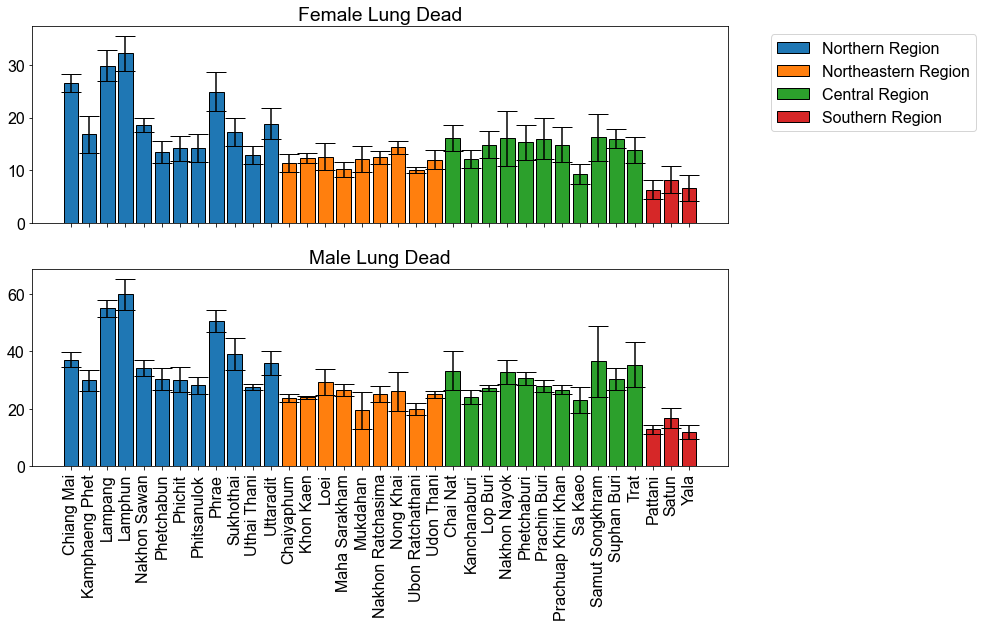

In [207]:
fig, ax = plt.subplots(2,1, figsize=(14, 9), sharex=True)
#ax.bar(pm10_short_list['province'], pm10_short_list['avgPM10'])


for region in region_list:
    # select province
    prov_in_region = provinces[provinces['region'] == region]['province'].to_list()
    # select only province near Chiang Mai
    # use province_list to keep the bar plot in the same order

    prov_in_region = [s for s in near_income_list if s in prov_in_region]
    df = mean_rate[mean_rate['province'].isin(prov_in_region) & (mean_rate['gender'] == 'Female')]
     
    if len(df) > 0:
        ax[0].bar(df['province'], df['rate'], yerr=df['rate_std'], label=region, edgecolor='black', capsize=10)
        
         
    df = mean_rate[mean_rate['province'].isin(prov_in_region) & (mean_rate['gender'] == 'Male')]
     
    if len(df) > 0:
        ax[1].bar(df['province'], df['rate'], yerr=df['rate_std'], label=region, edgecolor='black', capsize=10)
        
        
# highlight Chiang Mai
#df = dead_male_short.loc[['Chiang Mai']]
#ax[0].bar(df.index, df['lung_dead'], color='magenta', label='Chiang Mai', edgecolor='black')

#df = dead_female_short.loc[['Chiang Mai']]
#ax[1].bar(df.index, df['lung_dead'], color='magenta', label='Chiang Mai', edgecolor='black')

 
ax[0].legend(bbox_to_anchor=(1.05, 1.0))
plt.draw()
ax[0].set_title('Female Lung Dead')
ax[1].set_title('Male Lung Dead')

ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90);

plt.tight_layout()
plt.savefig(mdataset.report_folder + 'lung_15-20_bar.png', dpi=300)

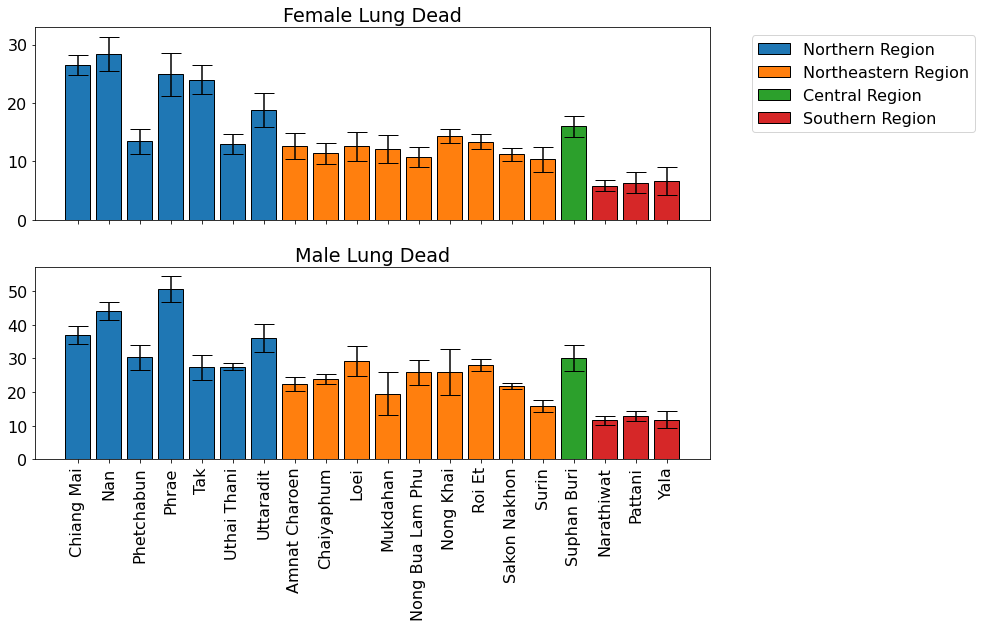

In [257]:
fig, ax = plt.subplots(2,1, figsize=(14, 9), sharex=True)
#ax.bar(pm10_short_list['province'], pm10_short_list['avgPM10'])


for region in region_list:
    # select province
    prov_in_region = provinces[provinces['region'] == region]['province'].to_list()
    # select only province near Chiang Mai
    # use province_list to keep the bar plot in the same order

    prov_in_region = [s for s in near_income_list if s in prov_in_region]
    df = mean_rate[mean_rate['province'].isin(prov_in_region) & (mean_rate['gender'] == 'Female')]
     
    if len(df) > 0:
        ax[0].bar(df['province'], df['rate'], yerr=df['rate_std'], label=region, edgecolor='black', capsize=10)
        
         
    df = mean_rate[mean_rate['province'].isin(prov_in_region) & (mean_rate['gender'] == 'Male')]
     
    if len(df) > 0:
        ax[1].bar(df['province'], df['rate'], yerr=df['rate_std'], label=region, edgecolor='black', capsize=10)
        
        
# highlight Chiang Mai
#df = dead_male_short.loc[['Chiang Mai']]
#ax[0].bar(df.index, df['lung_dead'], color='magenta', label='Chiang Mai', edgecolor='black')

#df = dead_female_short.loc[['Chiang Mai']]
#ax[1].bar(df.index, df['lung_dead'], color='magenta', label='Chiang Mai', edgecolor='black')

 
ax[0].legend(bbox_to_anchor=(1.05, 1.0))
plt.draw()
ax[0].set_title('Female Lung Dead')
ax[1].set_title('Male Lung Dead')

ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90);


plt.tight_layout()

# In Patient

In [388]:
near_income_list = ['Chaiyaphum',
 'Chiang Mai',
 'Pattani',
 'Uthai Thani',
 'Loei',
 'Phrae',
 'Phetchabun',
 'Mukdahan',
 'Nong Khai',
 'Yala',
 'Uttaradit',
 'Suphan Buri',
 'Khon Kaen',
 'Sukhothai',
 'Sa Kaeo',
 'Lampang',
 'Phitsanulok',
 'Maha Sarakham',
 'Ubon Ratchathani',
 'Phichit',
 'Nakhon Sawan',
 'Kanchanaburi',
 'Kamphaeng Phet',
 'Udon Thani',
 'Nakhon Ratchasima',
 'Lamphun',
 'Satun',
 'Lop Buri',
 'Nakhon Nayok',
 'Samut Songkhram',
 'Chai Nat',
 'Phattalung',
 'Prachuap Khiri Khan',
 'Prachin Buri',
 'Trat',
 'Phetchaburi']

In [389]:
population = pd.read_csv(mdataset.health_folder  + 'process/pop_prov.csv')  
population = population.drop(['province_th', 'gender_th'], axis=1)

pop = population.melt(id_vars=['province', 'gender'], var_name='year', value_name='pop')
pop['year'] = pop['year'].astype(int)
in_pat = pd.read_csv(mdataset.health_folder + 'process/in_patient_2007_2019.csv').dropna()
in_pat['year'] = in_pat['year'].astype(int)

in_pat = in_pat[~in_pat['year'].isin([2013, 2016])]
# add population 
in_pat = in_pat.merge(pop, on=['province', 'gender', 'year'], how='left')


# add birth rate
birth_rate = pd.read_csv(mdataset.health_folder  + 'process/birth_prov_w_gender.csv')
birth_rate = birth_rate.rename(columns={'number':'birth_number'})
birth_rate['year'] = birth_rate['year'].astype(int)

in_pat = in_pat.merge(birth_rate, on=['province',  'year', 'gender'], how='left')

# load provinces & region information 
provinces = mdataset.prov_map[['region', 'province']]

region_list = ['Northern Region', 'Northeastern Region', 'Central Region','Greater Bangkok','Southern Region']

# add region
in_pat = in_pat.merge(provinces, on='province', how='left')

# remove use number and remove total in gender 
in_pat = in_pat[(in_pat['number_type'] == 'number') & (in_pat['gender'].isin(['Male', 'Female'])) ]
in_pat = in_pat[~in_pat['region'].isna()]


In [390]:
in_pat['disease'].unique().shape

(298,)

In [141]:
cause = in_pat['disease'].drop_duplicates().reset_index(drop=True)
birth_defect = cause[cause.str.contains('ครรภ์') | cause.str.contains('กำเนิด')| cause.str.contains('แรกเกิด')| cause.str.contains('ทารก')].to_list()
birth_defect = [ 
 'Other pregnancies with abortive outcome (O00-O02, O05-O08)\nการตั้งครรภ์อื่น ๆ ที่สิ้นสุดโดยการแท้ง',
 'Oedema, proteinuria and hypertensive disorders in pregnancy, childbirth and the puerperium (O10-O16)\nการบวม การมีโปรตีนในปัสสาวะ และความดันโลหิตสูงขณะตั้งครรภ์ ระยะคลอด และระยะหลังคลอด',
 'Other maternal care related to fetus and amniotic cavity and possible delivery problems (O30-O43, O47-O48)\nการดูแลมารดาอื่น ๆ ที่มีปัญหาเกี่ยวกับทารกในครรภ์ และถุงน้ำคร่ำ และปัญหาที่อาจจะเกิดได้ในระยะคลอด',
 'Other complications of pregnancy and delivery (O20-O29, O60-O63, O67-O71, O73-O75, O81-O84)\nภาวะแทรกซ้อนอื่น ๆของการตั้งครรภ์ และการคลอด',
 'Fetus and newborn affected by maternal factors and by complications of pregnancy, labour and delivery (P00-P04)\nทารกในครรภ์และแรกเกิดที่ได้รับผลจากปัจจัยทางมารดา และโรคแทรกในระยะตั้งครรภ์ เจ็บครรภ์ และคลอด',
 'Slow fetal growth, fetal malnutrition and disorders related to short gestation and low birth weight (P05-P07)\nทารกในครรภ์โตช้า ทารกในครรภ์ขาดสารอาหาร และความผิดปกติเกี่ยวกับการตั้งครรภ์ระยะสั้น และน้ำหนักทารกแรกเกิดน้อย',
 'Intrauterine hypoxia and birth asphyxia (P20-P21)\nขาดออกซิเจนขณะอยู่ในโพรงมดลูก และภาวะแอสฟิกเซียเมื่อแรกเกิด',
 'Other infections specIfic to the perinatal period (P38-P39)\nการติดเชื้อเฉพาะอื่น ๆ ในระยะปริกำเนิด',
 'Haemolytic disease of fetus and newborn (P55)\nโรคเม็ดเลือดแตกของทารกในครรภ์และแรกเกิด',
 'Other conditions originating in the perinatal period (P08, P29, P50-P54, P56-P96)\nภาวะอื่น ๆ ในระยะปริกำเนิด',
 'Other congenital malformations of the nervous system (Q00-Q04, Q06-Q07)\nความผิดปกติอื่น ๆ แต่กำเนิดของระบบประสาท',
 'Congenital malformation of the circulatory system (Q20-Q28)\nความผิดปกติแต่กำเนิดของระบบไหลเวียนโลหิต',
 'Other congenital malformations of the digestive system (Q38-Q40, Q42-Q45)\nความผิดปกติแต่กำเนิดอื่น ๆ ของระบบย่อยอาหาร',
 'Congenital deformities of hip (Q65)\nความพิการแต่กำเนิดของสะโพก',
 'Congenital deformities of feet (Q66)\nความพิการแต่กำเนิดของเท้า',
 'Other congenital malformations and deformations of the musculoskeletal system (Q67-Q79)\nความผิดปกติและความพิการแต่กำเนิดอื่น ๆ ของระบบกล้ามเนื้อและโครงร่าง',
 'Other congenital malformations (Q10-Q18, Q30-Q34, Q80-Q89)\nความผิดปกติแต่กำเนิดอื่น ๆ']

## Compare Region

In [142]:
region_to_compare = ['Northern Region', 'Northeastern Region', 'Southern Region', 'Central Region']

# pick only three regions
in_pat_3reg = in_pat[in_pat['region'].isin(region_to_compare)]

# calculate the rate by cause_of_dead by year, gender, region
in_pat_3reg = in_pat_3reg.groupby(['year', 'gender', 'disease', 'region' ]).sum()

# calcule rate
in_pat_3reg['rate'] = in_pat_3reg['number']/in_pat_3reg['pop']

# calculate average over the years
in_pat_3reg_global = in_pat_3reg.reset_index()

In [143]:
significant_df1 = []
for year, gender, cause in zip(in_pat_3reg_global['year'], in_pat_3reg_global['gender'], in_pat_3reg_global['disease']):
    temp = in_pat_3reg_global[(in_pat_3reg_global['year']==year) &(in_pat_3reg_global['gender']==gender) & (in_pat_3reg_global['disease']==cause )]
    temp = temp.set_index('region')
    if len(temp) == 4:
        row_ne = temp.loc['Northeastern Region']
        row_s = temp.loc['Southern Region']
        z1 = cal_1z_test(row_ne, row_s) 
        
        row_n = temp.loc['Northern Region']
        
        z2 = cal_1z_test(row_n, row_s) 
        
        row_c = temp.loc['Central Region']
      
        z3 = cal_1z_test(row_c, row_s) 
        
        significant_df1.append([year, gender, cause, z1, z2, z3, row_n['rate']/row_s['rate'], row_ne['rate']/row_s['rate'], row_c['rate']/row_s['rate']] )
        
significant_df1 = pd.DataFrame(significant_df1, columns=['year', 'gender', 'disease', 'z_NE', 'z_N', 'z_C', 'ratio_north_south', 'ratio_northeast_south',  'ratio_central_south'])

# z2 should be more than z1
#significant_df1['north_higher_than_ne_c'] =  (significant_df1['z_N'] > significant_df1['z_NE']) & (significant_df1['z_N'] > significant_df1['z_C']) 
#significant_df1 = significant_df1[significant_df1['north_higher_than_ne_c'] == True]
significant_df1 = significant_df1.drop_duplicates()

In [144]:
remove_list = ['Acute hepatitis B (B16)\nตับอักเสบเฉียบพลันชนิดบี',
       'Alcohalic liver disease (K70)\nโรคตับเกี่ยวกับแอลกอฮอล์',
       'Blindness and low vision (H54)\nตาบอดและสายตาเลือนลาง',
       'Carcinoma in situ of cervix uteri (D06)\nมะเร็งจำกัดเฉพาะที่ของปากมดลูก',
       'Certain early complications of trauma and complications of surgical and medical care, note elsewhere classIfied (T79-T88)\nภาวะแทรกซ้อนระยะแรกของการบาดเจ็บบางชนิด และภาวะแทรกซ้อนของการรักษาทางศัลยกรรมและอายุรกรรมที่มิได้มีรหัสระบุไว้ที่อื่น',
       'Cervical and other intervertebral disc disorders (M50-M51)\nกระดูกสันหลังและหมอนรองกระดูกสันหลังอื่น ๆ ผิดปกติ',
       'Cholelithiasis and cholecysitis (K80-K81)\nโรคนิ่วในระบบน้ำดีและถุงน้ำดีอักเสบ',
       'Contraceptive management (Z30)\nการรับบริการคุมกำเนิด',
       'Dementia (F00-F03)\nสมองเสื่อม',
       'Diabetes mellitus (E10-E14)\nเบาหวาน',
       'Diseases of appendix (K35-K38)\nโรคของไส้ติ่ง',
       'Disorders of bone density and structure (M80-M85)\nความผิดปกติของความหนาแน่นของเนื้อกระดูกและโครงสร้าง',
       'Female genital prolapse (N81)\nการหย่อนตัวออกมาของอวัยวะสืบพันธุ์สตรี',
       'Gastric and duodenal ulcer (K25-K27)\nแผลเปื่อยของกระเพาะอาหารดูโอเดนัม',
       'Herpesviral infections (B00)\nเริม',
       'Injury of eye and orbit (S05)\nการบาดเจ็บของตาและเบ้าตา',
       'Malignant neoplasm of breast (C50)\nเนื้องอกร้ายที่เต้านม',
       'Malignant neoplasm of cervix uteri (C53)\nเนื้องอกร้ายที่ปากมดลูก',
       'Malignant neoplasm of colon (C18)\nเนื้องอกร้ายของลำไส้ใหญ่',
       'Malignant neoplasm of liver and intrahepatic bile ducts (C22)\nเนื้องอกร้ายที่ตับและท่อน้ำดีในตับ',
       'Malignant neoplasm of other and unspecified parts of uterus (C54-C55)\n เนื้องอกร้ายอื่น ๆ ที่มิได้ระบุส่วนของมดลูก',
       'Malignant neoplasm of other, ill-defined, secondary, unspecIfied and multiple sites (C73-C80, C97)\nเนื้องอกอื่น ๆ และที่ไม่ทราบสาเหตุ เนื้องอกทุติยภูมิที่มิได้ระบุรายละเอียดและเกิดขึ้นหลายแห่ง',
       'Malignant neoplasm of rectosigmoid junction, rectum, anus and anal canal (C19-C21)\nเนื้องอกร้ายที่รอยต่อลำไส้ใหญ่เร็คตัมและซิกมอยด์ เร็คตัม ทวารหนักและช่องทวารหนัก',
       'Malignant neoplasm of stomach (C16)\nเนื้องอกร้ายที่กระเพาะอาหาร',
       'Malignant neoplasms of lip, oral cavity and pharynx (C00-C14)\nเนื้องอกร้ายของริมฝีปาก ช่องปาก และคอหอย',
       'Maltreatment syndromes (T74)\nกลุ่มอาการจากการทารุณ',
       'Mental and behavioral disorders due to use of alcohol (F10)\nความผิดปกติของพฤติกรรมและจิตประสาทที่เกิดจากการเสพแอลกอฮอล์',
       'Osteomyelitis (M86)\nกระดูกอักเสบ',
       'Other diseases of liver (K71-K77)\nโรคอื่น ๆ ของตับ',
       'Other diseases of the digestive system (K82-K83, K87-K93)\nโรคอื่น ๆ ของระบบย่อยอาหาร',
       'Other diseases of the nervous system (G10-G13, G21-G26, G31-G32, G36-G37, G46-G47, G60-G73, G90-G99)\nโรคของระบบประสาทอื่น ๆ',
       'Other diseases of the oral cavity, salivary glands and jaws (K09-K14)\nโรคอื่น ๆ ของช่องปาก ต่อมน้ำลายและขากรรไกร',
       'Other diseorders of joints (M00-M03, M22-M25)\nความผิดปกติอื่น ๆ ของข้อ',
       'Other disorders of teeth and supporting structures (K00-K01, K03-K08)\nความผิดปกติอื่น ๆ ของฟันและโครงสร้าง',
       'Other dorsopathies (M40-M49, M53-M54)\nพยาธิสภาพของหลังส่วนอื่น ๆ',
       'Other fluke infections (B66)\nโรคพยาธิใบไม้อื่น ๆ',
       'Other helminthiases (B68-B71, B75, B77-B83)\nโรคพยาธิตัวตืดอื่น ๆ',
       'Other intestinal infectious diseases (A02, A04-A05, A07-A08)\nโรคลำไส้อักเสบอื่น ๆ',
       'Other malignant neoplasms of digestive organs (C17, C23-C24, C26)\nเนื้องอกร้ายที่อวัยวะย่อยอาหารอื่น ๆ',
       'Other malignant neoplasms of female genital organs (C51-C52, C56-C58)\nเนื้องอกร้ายของอวัยวะสืบพันธุ์หญิง',
       'Other malignant neoplasms of skin (C44)\nเนื้องอกร้ายที่ผิวหนังอื่น ๆ',
       'Other mental and behavioral disorders (F04-F09, F50-F69, F80-F99)\nความผิดปกติทางจิตและพฤติกรรมอื่น ๆ',
       'Other tetanus (A34-A35)\nบาดทะยักอื่น ๆ',
       'Other viral hepatitis (B15, B17-B19)\nตับอักเสบจากไวรัสอื่น ๆ',
       'Paralytic ileus and intestinal obstruction without hernia (K56)\nลำไส้ไม่ทำงานและลำไส้เกิดอุดตันแบบไม่มีไส้เลื่อน',
       "Parkinson's disease (G20)\nโรคพาร์คินสัน",
       'Persons encountering health services for specIfic procedures and health care (Z40-Z54, Z40-Z54)\nบุคคลขอรับบริการสุขภาพ เพื่อหัตถการหรือการบริการสุขภาพที่ระบุเฉพาะ',
       'Renal failure (N17-N19)\nไตวาย',
       'Renal tubulo-interstitial diseases (N10-N16)\nโรคของท่อและเนื้อเยื่อระหว่างท่อในไต',
       'Rheumatoid arthritis and other inflammatory polyarthropathies (M05-M14)\nข้ออักเสบรูห์มาตอยและข้ออักเสบหลายข้อ',
       'Schizophrenia, schizotypal and delusional disorders (F20-F29)\nจิตเภท พฤติกรรมแบบจิตเภทและความหลงผิด',
       'Senility (R54)\nชราภาพ', 
       'Urolithiasis (N20-N23)\nนิ่วในระบบทางเดินปัสสาวะ',
       'Acute pancreatitis and other diseases of the pancreas (K85-K86)\nตับอ่อนอักเสบเฉียบพลันและโรคอื่น ๆ ของตับอ่อน',
       'Crushing injuries and traumatic amputations of specIfied and multiple body regions (S07-S08, S17-S18, S28, S38, S47-S48, S57-S58, S67-S68, S77-S78, S87-S88, S97-S98, T04-T05)\nการบาดเจ็บจากการบดอัดและการบาดเจ็บที่เกิดจากตัดขาบริเวณร่างกายหลายแห่งที่ระบุเฉพาะ',
       'Dislocations, sprains and strains of specIfied and multiple body regions (S03, S13, S23, S33, S43,S53, S63, S73, S83, S93, T03)\nกระดูกเคลื่อน เคล็ด ขัด บริเวณร่างกายหลายแห่งที่ระบุเฉพาะ',
       'Fractures of other limb bones (S42, S52, S62, S82, S92, T10, T12)\nกระดูกแตกหักของแขนขาอื่น ๆ',
       'Other diseases of the urinary system (N25-N29, N31-N39)\nโรคอื่น ๆ ของระบบทางเดินปัสสาวะ',
       'Other disorders of prostate (N41-N42)\nความผิดปกติอื่น ๆ ของต่อมลูกหมาก',
       'Other infections with a predominantly sexual mode of transmission (A57-A64)\nโรคติดเชื้ออื่น ๆ ที่ติดต่อทางเพศสัมพันธ์เป็นส่วนมาก',
       'Other vitamin deficiencies (E51-E56)\nการขาดวิตามินอื่น ๆ',
       'Persons encountering health services for other reasons (Z31-Z33, Z37, Z55-Z99)\nบุคคลขอรับบริการสุขภาพด้วยเหตุผลอื่น',
       'Redundant prepuce, phimosis and paraphimosis (N47)\nหนังหุ้มปลายองคชาติยาวเกินไป ปลายตีบรูเปิดไม่ได้หรือเปิดลำบาก',
        'Other anaemias (D51-D64)\nโลหิตจางอื่น ๆ',
        'Other Endocrine, nutritional and metabolic disorders (E15-E35, E58-E63, E65, E67-E85, E87-E90)\nความผิดปกติของต่อมไร้ท่อ โภชนาการและเมตะบอลิกอื่น ๆ'
              ]

significant_df1 = significant_df1[~significant_df1['disease'].isin(remove_list)]

 ## Compare Provinces with similar income

In [145]:
region_to_compare = ['Northern Region', 'Northeastern Region', 'Southern Region', 'Central Region']

# pick only three regions
in_pat_3reg = in_pat[in_pat['region'].isin(region_to_compare) & in_pat['province'].isin(near_income_list)]

# calculate the rate by cause_of_dead by year, gender, region
in_pat_3reg = in_pat_3reg.groupby(['year', 'gender', 'disease', 'region' ]).sum()

# calcule rate
in_pat_3reg['rate'] = in_pat_3reg['number']/in_pat_3reg['pop']

# calculate average over the years
in_pat_3reg_spec = in_pat_3reg.reset_index()

In [146]:
significant_df2 = []
for year, gender, cause in zip(in_pat_3reg_spec['year'],in_pat_3reg_spec['gender'], in_pat_3reg_spec['disease']):
    temp = in_pat_3reg_spec[(in_pat_3reg_spec['year']==year) & (in_pat_3reg_spec['gender']==gender) & (in_pat_3reg_spec['disease']==cause )]
    temp = temp.set_index('region')
    if len(temp) == 4:
        row_ne = temp.loc['Northeastern Region']
        row_s = temp.loc['Southern Region']
        z1 = cal_1z_test(row_ne, row_s) 
        
        row_n = temp.loc['Northern Region']
        
        z2 = cal_1z_test(row_n, row_s) 
        
        row_c = temp.loc['Central Region']
      
        z3 = cal_1z_test(row_c, row_s) 
        
        significant_df2.append([year, gender, cause, z1, z2, z3 ] )
        
significant_df2 = pd.DataFrame(significant_df2, columns=['year', 'gender', 'disease', 'z_NE_income', 'z_N_income', 'z_C_income' ])

significant_df2 = significant_df2.drop_duplicates()

In [147]:
remove_list = ['Acute hepatitis B (B16)\nตับอักเสบเฉียบพลันชนิดบี',
       'Alcohalic liver disease (K70)\nโรคตับเกี่ยวกับแอลกอฮอล์',
       'Blindness and low vision (H54)\nตาบอดและสายตาเลือนลาง',
       'Carcinoma in situ of cervix uteri (D06)\nมะเร็งจำกัดเฉพาะที่ของปากมดลูก',
       'Certain early complications of trauma and complications of surgical and medical care, note elsewhere classIfied (T79-T88)\nภาวะแทรกซ้อนระยะแรกของการบาดเจ็บบางชนิด และภาวะแทรกซ้อนของการรักษาทางศัลยกรรมและอายุรกรรมที่มิได้มีรหัสระบุไว้ที่อื่น',
       'Cervical and other intervertebral disc disorders (M50-M51)\nกระดูกสันหลังและหมอนรองกระดูกสันหลังอื่น ๆ ผิดปกติ',
       'Cholelithiasis and cholecysitis (K80-K81)\nโรคนิ่วในระบบน้ำดีและถุงน้ำดีอักเสบ',
       'Contraceptive management (Z30)\nการรับบริการคุมกำเนิด',
       'Dementia (F00-F03)\nสมองเสื่อม',
       'Diabetes mellitus (E10-E14)\nเบาหวาน',
       'Diseases of appendix (K35-K38)\nโรคของไส้ติ่ง',
       'Disorders of bone density and structure (M80-M85)\nความผิดปกติของความหนาแน่นของเนื้อกระดูกและโครงสร้าง',
       'Female genital prolapse (N81)\nการหย่อนตัวออกมาของอวัยวะสืบพันธุ์สตรี',
       'Gastric and duodenal ulcer (K25-K27)\nแผลเปื่อยของกระเพาะอาหารดูโอเดนัม',
       'Herpesviral infections (B00)\nเริม',
       'Injury of eye and orbit (S05)\nการบาดเจ็บของตาและเบ้าตา',
       'Malignant neoplasm of breast (C50)\nเนื้องอกร้ายที่เต้านม',
       'Malignant neoplasm of cervix uteri (C53)\nเนื้องอกร้ายที่ปากมดลูก',
       'Malignant neoplasm of colon (C18)\nเนื้องอกร้ายของลำไส้ใหญ่',
       'Malignant neoplasm of liver and intrahepatic bile ducts (C22)\nเนื้องอกร้ายที่ตับและท่อน้ำดีในตับ',
       'Malignant neoplasm of other and unspecified parts of uterus (C54-C55)\n เนื้องอกร้ายอื่น ๆ ที่มิได้ระบุส่วนของมดลูก',
       'Malignant neoplasm of other, ill-defined, secondary, unspecIfied and multiple sites (C73-C80, C97)\nเนื้องอกอื่น ๆ และที่ไม่ทราบสาเหตุ เนื้องอกทุติยภูมิที่มิได้ระบุรายละเอียดและเกิดขึ้นหลายแห่ง',
       'Malignant neoplasm of rectosigmoid junction, rectum, anus and anal canal (C19-C21)\nเนื้องอกร้ายที่รอยต่อลำไส้ใหญ่เร็คตัมและซิกมอยด์ เร็คตัม ทวารหนักและช่องทวารหนัก',
       'Malignant neoplasm of stomach (C16)\nเนื้องอกร้ายที่กระเพาะอาหาร',
       'Malignant neoplasms of lip, oral cavity and pharynx (C00-C14)\nเนื้องอกร้ายของริมฝีปาก ช่องปาก และคอหอย',
       'Maltreatment syndromes (T74)\nกลุ่มอาการจากการทารุณ',
       'Mental and behavioral disorders due to use of alcohol (F10)\nความผิดปกติของพฤติกรรมและจิตประสาทที่เกิดจากการเสพแอลกอฮอล์',
       'Osteomyelitis (M86)\nกระดูกอักเสบ',
       'Other diseases of liver (K71-K77)\nโรคอื่น ๆ ของตับ',
       'Other diseases of the digestive system (K82-K83, K87-K93)\nโรคอื่น ๆ ของระบบย่อยอาหาร',
       'Other diseases of the nervous system (G10-G13, G21-G26, G31-G32, G36-G37, G46-G47, G60-G73, G90-G99)\nโรคของระบบประสาทอื่น ๆ',
       'Other diseases of the oral cavity, salivary glands and jaws (K09-K14)\nโรคอื่น ๆ ของช่องปาก ต่อมน้ำลายและขากรรไกร',
       'Other diseorders of joints (M00-M03, M22-M25)\nความผิดปกติอื่น ๆ ของข้อ',
       'Other disorders of teeth and supporting structures (K00-K01, K03-K08)\nความผิดปกติอื่น ๆ ของฟันและโครงสร้าง',
       'Other dorsopathies (M40-M49, M53-M54)\nพยาธิสภาพของหลังส่วนอื่น ๆ',
       'Other fluke infections (B66)\nโรคพยาธิใบไม้อื่น ๆ',
       'Other helminthiases (B68-B71, B75, B77-B83)\nโรคพยาธิตัวตืดอื่น ๆ',
       'Other intestinal infectious diseases (A02, A04-A05, A07-A08)\nโรคลำไส้อักเสบอื่น ๆ',
       'Other malignant neoplasms of digestive organs (C17, C23-C24, C26)\nเนื้องอกร้ายที่อวัยวะย่อยอาหารอื่น ๆ',
       'Other malignant neoplasms of female genital organs (C51-C52, C56-C58)\nเนื้องอกร้ายของอวัยวะสืบพันธุ์หญิง',
       'Other malignant neoplasms of skin (C44)\nเนื้องอกร้ายที่ผิวหนังอื่น ๆ',
       'Other mental and behavioral disorders (F04-F09, F50-F69, F80-F99)\nความผิดปกติทางจิตและพฤติกรรมอื่น ๆ',
       'Other tetanus (A34-A35)\nบาดทะยักอื่น ๆ',
       'Other viral hepatitis (B15, B17-B19)\nตับอักเสบจากไวรัสอื่น ๆ',
       'Paralytic ileus and intestinal obstruction without hernia (K56)\nลำไส้ไม่ทำงานและลำไส้เกิดอุดตันแบบไม่มีไส้เลื่อน',
       "Parkinson's disease (G20)\nโรคพาร์คินสัน",
       'Persons encountering health services for specIfic procedures and health care (Z40-Z54, Z40-Z54)\nบุคคลขอรับบริการสุขภาพ เพื่อหัตถการหรือการบริการสุขภาพที่ระบุเฉพาะ',
       'Renal failure (N17-N19)\nไตวาย',
       'Renal tubulo-interstitial diseases (N10-N16)\nโรคของท่อและเนื้อเยื่อระหว่างท่อในไต',
       'Rheumatoid arthritis and other inflammatory polyarthropathies (M05-M14)\nข้ออักเสบรูห์มาตอยและข้ออักเสบหลายข้อ',
       'Schizophrenia, schizotypal and delusional disorders (F20-F29)\nจิตเภท พฤติกรรมแบบจิตเภทและความหลงผิด',
       'Senility (R54)\nชราภาพ', 
       'Urolithiasis (N20-N23)\nนิ่วในระบบทางเดินปัสสาวะ',
       'Acute pancreatitis and other diseases of the pancreas (K85-K86)\nตับอ่อนอักเสบเฉียบพลันและโรคอื่น ๆ ของตับอ่อน',
       'Crushing injuries and traumatic amputations of specIfied and multiple body regions (S07-S08, S17-S18, S28, S38, S47-S48, S57-S58, S67-S68, S77-S78, S87-S88, S97-S98, T04-T05)\nการบาดเจ็บจากการบดอัดและการบาดเจ็บที่เกิดจากตัดขาบริเวณร่างกายหลายแห่งที่ระบุเฉพาะ',
       'Dislocations, sprains and strains of specIfied and multiple body regions (S03, S13, S23, S33, S43,S53, S63, S73, S83, S93, T03)\nกระดูกเคลื่อน เคล็ด ขัด บริเวณร่างกายหลายแห่งที่ระบุเฉพาะ',
       'Fractures of other limb bones (S42, S52, S62, S82, S92, T10, T12)\nกระดูกแตกหักของแขนขาอื่น ๆ',
       'Other diseases of the urinary system (N25-N29, N31-N39)\nโรคอื่น ๆ ของระบบทางเดินปัสสาวะ',
       'Other disorders of prostate (N41-N42)\nความผิดปกติอื่น ๆ ของต่อมลูกหมาก',
       'Other infections with a predominantly sexual mode of transmission (A57-A64)\nโรคติดเชื้ออื่น ๆ ที่ติดต่อทางเพศสัมพันธ์เป็นส่วนมาก',
       'Other vitamin deficiencies (E51-E56)\nการขาดวิตามินอื่น ๆ',
       'Persons encountering health services for other reasons (Z31-Z33, Z37, Z55-Z99)\nบุคคลขอรับบริการสุขภาพด้วยเหตุผลอื่น',
       'Redundant prepuce, phimosis and paraphimosis (N47)\nหนังหุ้มปลายองคชาติยาวเกินไป ปลายตีบรูเปิดไม่ได้หรือเปิดลำบาก',
        'Other anaemias (D51-D64)\nโลหิตจางอื่น ๆ',
        'Other Endocrine, nutritional and metabolic disorders (E15-E35, E58-E63, E65, E67-E85, E87-E90)\nความผิดปกติของต่อมไร้ท่อ โภชนาการและเมตะบอลิกอื่น ๆ'
              ]

significant_df2 = significant_df2[~significant_df2['disease'].isin(remove_list)]

In [148]:
significant_df2.shape

(5020, 6)

In [149]:
significant_df_merge = significant_df1.merge(significant_df2, on=['year', 'gender', 'disease'], how='inner')
significant_df_merge.shape

(5020, 12)

In [151]:
significant_df_merge.to_csv(mdataset.health_folder  + 'process/' + 'in_patient_narrow.csv', index=False, encoding='utf-8')

In [152]:
in_pat_sig_merge = pd.read_csv(mdataset.health_folder  + 'process/' + 'in_patient_narrow.csv')

In [157]:
in_pat_sig_avg = in_pat_sig_merge.groupby(['gender', 'disease'], as_index=False).mean()

In [159]:
inpat_narrow = in_pat_sig_avg[(in_pat_sig_avg['z_N']> 1.96 ) & (in_pat_sig_avg['z_NE']> 1.96 )] 
inpat_narrow['disease'].unique()

array(['Chronic rheumatic heart disease (I05-I09)\nโรคหัวใจรูมาติกเรื้อรัง',
       'Conduction disorders and cardiac arrhythmias (I44-I49)\nความผิดปกติของการนำกระแสไฟฟ้าหัวใจและหัวใจเต้นผิดจังหวะ',
       'Conjunctivitis and other disorders of conjunctiva (H10-H13)\nเยื่อบุตาอักเสบและความผิดปกติของเยื่อบุตาอื่น ๆ',
       'Glaucoma (H40-H42)\nต้อหิน',
       'Haemorrhagic conditions and other diseases of blood and blood-forming organs (D65-D77)\nภาวะเลือดออกอื่น ๆ โรคเลือดและอวัยวะที่สร้างเลือด',
       'Inflammatory diseases of the central nervous system (G00-G09)\nการอักเสบของระบบประสาทส่วนกลาง',
       'Iron deficiency anaemia (D50)\nโลหิตจางจากการขาดธาตุเหล็ก',
       'Keratitis and other disorders of sclera and cornea (H15-H19)\nกระจกตาอักเสบและความผิดปกติของตาขาวและกระจกตาอื่น ๆ',
       'Malignant neoplasm of trachea, bronchus and lung (C33-C34)\nเนื้องอกร้ายที่หลอดคอ หลอดลม และปอด',
       'Mycoses (B35-B49)\nโรคติดเชื้อรา',
       "Non-Hodgkin's lymphoma (C82-C85)\nเนื้องอกร้

In [294]:
higher_female = []
for dis in in_pat_sig_dis:
    temp = in_pat_sig_avg[in_pat_sig_avg['disease'] == dis]
    if len(temp)== 2:
        temp = temp.set_index('gender')
        if (temp.loc['Female', 'z_N'] > temp.loc['Male', 'z_N']):
            
            higher_female.append(dis)

In [295]:
higher_female

['Chronic rheumatic heart disease (I05-I09)\nโรคหัวใจรูมาติกเรื้อรัง',
 'Conduction disorders and cardiac arrhythmias (I44-I49)\nความผิดปกติของการนำกระแสไฟฟ้าหัวใจและหัวใจเต้นผิดจังหวะ',
 'Glaucoma (H40-H42)\nต้อหิน',
 'Haemorrhagic conditions and other diseases of blood and blood-forming organs (D65-D77)\nภาวะเลือดออกอื่น ๆ โรคเลือดและอวัยวะที่สร้างเลือด',
 'Keratitis and other disorders of sclera and cornea (H15-H19)\nกระจกตาอักเสบและความผิดปกติของตาขาวและกระจกตาอื่น ๆ',
 'Malignant neoplasm of trachea, bronchus and lung (C33-C34)\nเนื้องอกร้ายที่หลอดคอ หลอดลม และปอด',
 'Phlebitis, thrombophlebitis,venous embolism and thrombosis (I80-I82)\nหลอดเลือดดำอักเสบ หลอดเลือดดำอักเสบมีลิ่มเลือดก้อนเลือดและลิ่มเลือดในหลอดเลือดดำ',
 'Systemic connective tissue disorders (M30-M36)\nความผิดปกติของระบบเนื้อเยื่อประสาน']

In [161]:
includes = ['Chronic rheumatic heart disease (I05-I09)\nโรคหัวใจรูมาติกเรื้อรัง',
       'Conduction disorders and cardiac arrhythmias (I44-I49)\nความผิดปกติของการนำกระแสไฟฟ้าหัวใจและหัวใจเต้นผิดจังหวะ',
       'Haemorrhagic conditions and other diseases of blood and blood-forming organs (D65-D77)\nภาวะเลือดออกอื่น ๆ โรคเลือดและอวัยวะที่สร้างเลือด',
       'Inflammatory diseases of the central nervous system (G00-G09)\nการอักเสบของระบบประสาทส่วนกลาง',
        'Malignant neoplasm of trachea, bronchus and lung (C33-C34)\nเนื้องอกร้ายที่หลอดคอ หลอดลม และปอด',
        'Other Tuberculosis (A17-A19)\nวัณโรคอื่น ๆ',
       'Other diseases of the circulatory system (I85-I99) \nโรคอื่น ๆ ของระบบไหลเวียนโลหิต',
       'Other heart diseases (I27-I43, I51-I52)\nโรคหัวใจอื่น ๆ',
        'Phlebitis, thrombophlebitis,venous embolism and thrombosis (I80-I82)\nหลอดเลือดดำอักเสบ หลอดเลือดดำอักเสบมีลิ่มเลือดก้อนเลือดและลิ่มเลือดในหลอดเลือดดำ',
       'Respiratory tuberculosis (A15-A16)\nวัณโรคทางเดินหายใจ',
        'Systemic connective tissue disorders (M30-M36)\nความผิดปกติของระบบเนื้อเยื่อประสาน',
       'Bronchioectasis (J47)\nโรคหลอดลมเล็กโป่งพอง',
        'Other malignant neoplasms of respiratory and intrathoracic organs \n(C30-C31, C37-C39)\nเนื้องอกร้ายที่อวัยวะหายใจและอวัยวะช่องอก']

In [164]:
inpat_narrow[inpat_narrow['disease'].isin(includes)].sort_values(['z_N', 'z_NE', 'z_C'], ascending=False).round(2) 

,gender,disease,year,z_NE,z_N,z_C,ratio_north_south,ratio_northeast_south,ratio_central_south,z_NE_income,z_N_income,z_C_income
111,Female,"Malignant neoplasm of trachea, bronchus and lu...",2012.73,5.98,26.30,6.10,2.61,1.26,1.30,11.37,15.48,8.20
344,Male,"Malignant neoplasm of trachea, bronchus and lu...",2012.73,2.76,24.21,5.58,1.91,1.08,1.19,14.19,18.36,10.24
384,Male,Other diseases of the circulatory system (I85-...,2012.73,6.10,22.55,14.33,2.34,1.27,1.75,8.13,14.12,9.40
41,Female,Conduction disorders and cardiac arrhythmias (...,2012.73,20.75,22.26,17.39,1.74,1.61,1.55,16.02,16.56,13.65
274,Male,Conduction disorders and cardiac arrhythmias (...,2012.73,13.61,15.87,12.23,1.60,1.45,1.45,10.33,11.15,8.23
151,Female,Other diseases of the circulatory system (I85-...,2012.73,3.20,15.74,10.80,2.12,1.17,1.71,5.52,10.37,7.79
321,Male,Inflammatory diseases of the central nervous s...,2012.73,14.25,14.39,2.90,1.96,1.88,1.16,8.24,7.53,1.81
88,Female,Inflammatory diseases of the central nervous s...,2012.73,11.81,9.32,2.81,1.75,1.92,1.20,6.47,4.83,1.19
394,Male,"Other heart diseases (I27-I43, I51-I52)\nโรคหั...",2012.73,6.60,9.01,-2.62,1.44,1.28,0.89,8.49,6.73,-2.57
429,Male,Respiratory tuberculosis (A15-A16)\nวัณโรคทางเ...,2012.73,16.20,8.14,7.92,1.22,1.43,1.21,7.29,6.06,5.63


## Visualization

In [258]:
significant_df_merge = pd.read_csv(mdataset.health_folder  + 'process/' + 'in_patient_narrow.csv')

In [270]:
significant_df_merge['disease'].value_counts()[significant_df_merge['disease'].value_counts() == 2].index

Index(['Systemic connective tissue disorders (M30-M36)\nความผิดปกติของระบบเนื้อเยื่อประสาน',
       'Malignant neoplasm of trachea, bronchus and lung (C33-C34)\nเนื้องอกร้ายที่หลอดคอ หลอดลม และปอด',
       'Other diseases of the circulatory system (I85-I99) \nโรคอื่น ๆ ของระบบไหลเวียนโลหิต',
       'Septicemia (A40-A41)\nโลหิตเป็นพิษ',
       'Conduction disorders and cardiac arrhythmias (I44-I49)\nความผิดปกติของการนำกระแสไฟฟ้าหัวใจและหัวใจเต้นผิดจังหวะ'],
      dtype='object')

In [392]:
dis_list = ['Systemic connective tissue disorders (M30-M36)\nความผิดปกติของระบบเนื้อเยื่อประสาน',
       'Malignant neoplasm of trachea, bronchus and lung (C33-C34)\nเนื้องอกร้ายที่หลอดคอ หลอดลม และปอด',
       'Other diseases of the circulatory system (I85-I99) \nโรคอื่น ๆ ของระบบไหลเวียนโลหิต',
       'Septicemia (A40-A41)\nโลหิตเป็นพิษ',
       'Conduction disorders and cardiac arrhythmias (I44-I49)\nความผิดปกติของการนำกระแสไฟฟ้าหัวใจและหัวใจเต้นผิดจังหวะ']

In [393]:
dis = dis_list[1]
print(dis)
# dis = 'Other congenital malformations of the nervous system (Q00-Q04, Q06-Q07)\nความผิดปกติอื่น ๆ แต่กำเนิดของระบบประสาท'

Malignant neoplasm of trachea, bronchus and lung (C33-C34)
เนื้องอกร้ายที่หลอดคอ หลอดลม และปอด


In [394]:
# calculate the rate by cause_of_in_pat by year, gender, region
in_pat_reg = in_pat.groupby(['year', 'gender', 'disease', 'region' ]).sum()

# calcule rate
in_pat_reg['rate'] = in_pat_reg['number']/in_pat_reg['pop']

# reset index
in_pat_reg = in_pat_reg.reset_index()

one_disease = in_pat_reg[in_pat_reg['disease'] == dis]

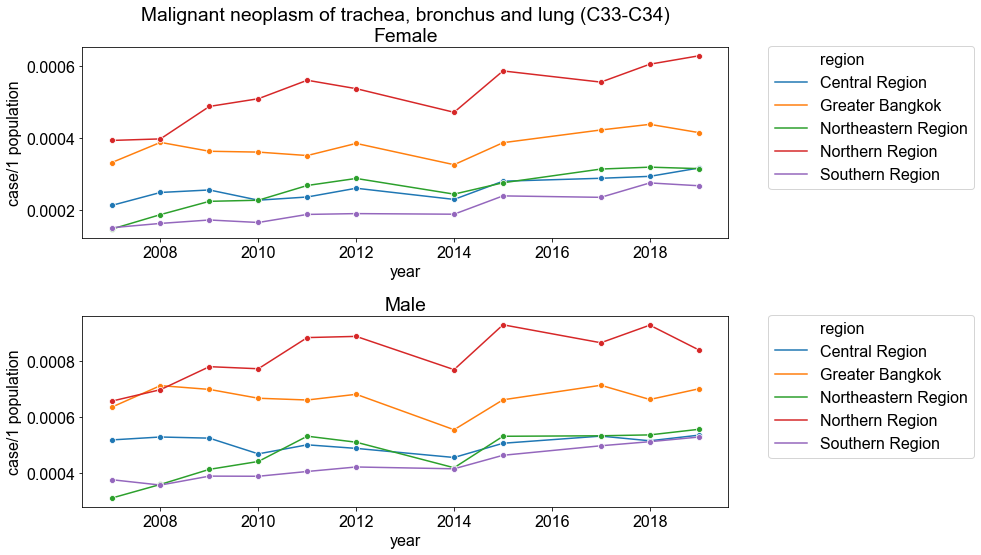

In [395]:
_, ax = plt.subplots(2,1, figsize=(14,8))

df = one_disease[one_disease['gender']=='Female']
sns.lineplot(data=df, x='year', y='rate', hue='region', ax=ax[0], marker='o')

df = one_disease[one_disease['gender']=='Male']
sns.lineplot(data=df, x='year', y='rate', hue='region', ax=ax[1], marker='o')

for a, t in zip(ax, [dis.split('\n')[0] + '\nFemale', 'Male']):
    a.set_title(t)
    a.legend(bbox_to_anchor=(1.05, 1.05))
    a.set_ylabel('case/1 population')
    
plt.tight_layout()
plt.savefig(mdataset.report_folder + 'inpat_lung_over_years.png', dpi=300)

In [396]:
# select year 
temp = in_pat[in_pat['year'].isin(np.arange(2015, 2020))]
mean_rate = temp.groupby(['year', 'gender', 'disease', 'province' ]).sum()

# calcule rate
mean_rate['rate'] = mean_rate['number']/mean_rate['pop']*1000

# reset index
mean_rate = mean_rate.reset_index()
mean_rate = mean_rate[mean_rate['disease'] == dis]

# average of the rate
std_rate = mean_rate.groupby([ 'gender', 'disease', 'province'], as_index=False).std()

mean_rate = mean_rate.groupby([ 'gender', 'disease', 'province'], as_index=False).mean()

mean_rate = mean_rate.merge(std_rate, on=[ 'gender', 'disease', 'province'], suffixes=('', '_std'))

# create a map of pollution by merging with the shape file 
plot_map = mdataset.prov_map.merge(mean_rate, on='province', how='left')

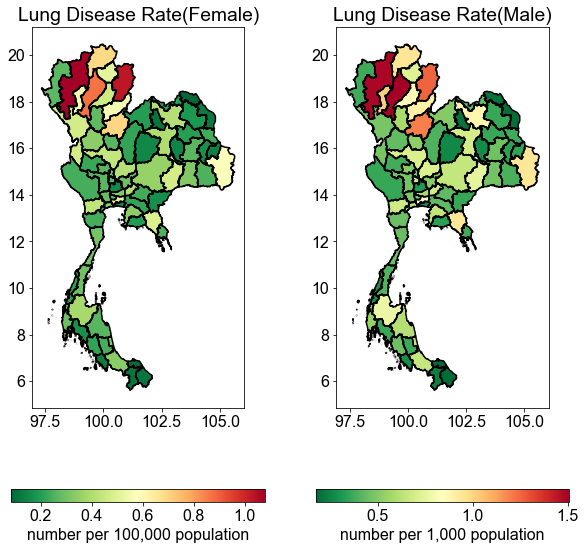

In [256]:
_, ax = plt.subplots(1, 2, figsize=(10,10))

df = plot_map[plot_map['gender']=='Female']

df.plot(column='rate',
           ax=ax[0],legend=True,
           legend_kwds={'label': "number per 100,000 population",
                       'orientation': "horizontal"},  cmap='RdYlGn_r',
             missing_kwds={
         "color": "lightgrey",
         "edgecolor": "red",
            "hatch": "///",
           "label": "Missing values" },)

 
df.boundary.plot(ax=ax[0], color='black')

df = plot_map[plot_map['gender']=='Male']

df.plot(column='rate',
           ax=ax[1],legend=True,
           legend_kwds={'label': "number per 1,000 population",
                       'orientation': "horizontal"},  cmap='RdYlGn_r',
             missing_kwds={
         "color": "lightgrey",
         "edgecolor": "red",
            "hatch": "///",
           "label": "Missing values" },)

 
df.boundary.plot(ax=ax[1], color='black')

ax[0].set_title("Lung Malignant Rate(Female)")
ax[1].set_title("Lung Malignant Rate(Male)");

plt.savefig(mdataset.report_folder + 'inpat_lung_15-20_map.png', dpi=300)

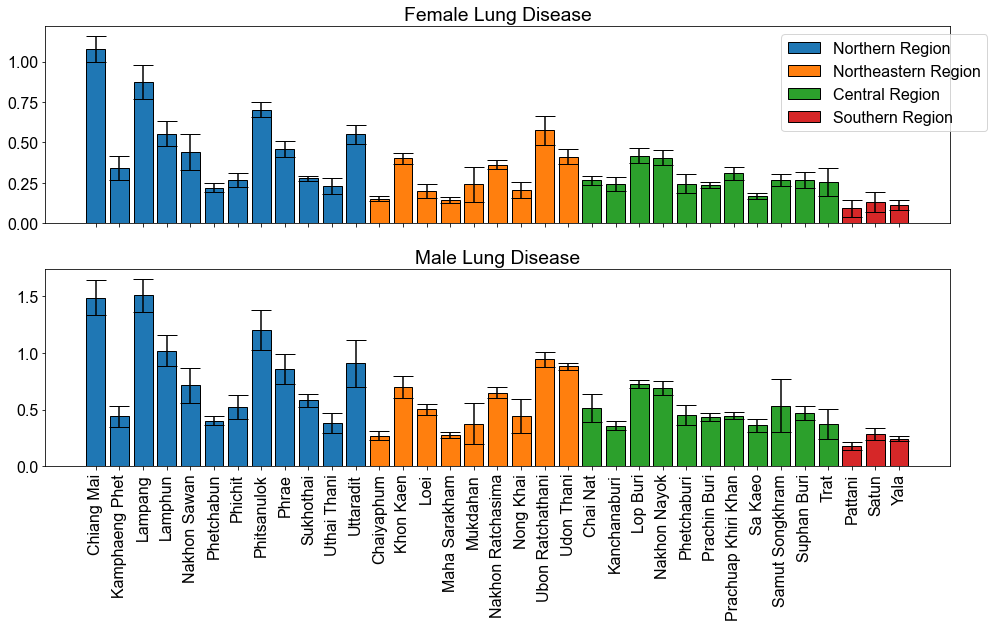

In [397]:
fig, ax = plt.subplots(2,1, figsize=(14, 9), sharex=True)
#ax.bar(pm10_short_list['province'], pm10_short_list['avgPM10'])


for region in region_list:
    # select province
    prov_in_region = provinces[provinces['region'] == region]['province'].to_list()
    # select only province near Chiang Mai
    # use province_list to keep the bar plot in the same order

    prov_in_region = [s for s in near_income_list if s in prov_in_region]
    df = mean_rate[mean_rate['province'].isin(prov_in_region) & (mean_rate['gender'] == 'Female')]
     
    if len(df) > 0:
        ax[0].bar(df['province'], df['rate'], yerr=df['rate_std'], label=region, edgecolor='black', capsize=10)
        
         
    df = mean_rate[mean_rate['province'].isin(prov_in_region) & (mean_rate['gender'] == 'Male')]
     
    if len(df) > 0:
        ax[1].bar(df['province'], df['rate'], yerr=df['rate_std'], label=region, edgecolor='black', capsize=10)
        
        
# highlight Chiang Mai
#df = dead_male_short.loc[['Chiang Mai']]
#ax[0].bar(df.index, df['lung_dead'], color='magenta', label='Chiang Mai', edgecolor='black')

#df = dead_female_short.loc[['Chiang Mai']]
#ax[1].bar(df.index, df['lung_dead'], color='magenta', label='Chiang Mai', edgecolor='black')

 
ax[0].legend(bbox_to_anchor=(1.05, 1.0))
plt.draw()
ax[0].set_title('Female Lung Disease')
ax[1].set_title('Male Lung Disease')

ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90);

plt.tight_layout()
plt.savefig(mdataset.report_folder + 'inpat_lung_15-20_bar.png', dpi=300)

## Modeling

input candidates

- Yearly average PM2.5 pollution level by province. Fill the value of the missing province with the near by provinces.
- Gender 
- Literacy rate : educated people tend to avoid going outside during the pollution season
- Average income (scaled by the average of the same year) 
- Smoking rate : for lung-related illness 
- Population ratio breakdown by ages (need to put together the data first)
- population size (normalized by average province size)

Prepare pollution data for modeling

In [257]:
# prepare pollution data
mdataset = MapDataset('Thailand')
mdataset.load_()

# build or load pollution by province and add as .poll attribute
mdataset.load_poll_prov(pollutant='PM2.5')

# calculate the yearly average only during the winter season
#poll attributes 
poll = mdataset.poll
poll = add_season(poll, start_month='-10-01', end_month='-05-15')
# keep only winter season 
poll = poll[poll['season'] != 'other']

#poll['year'] =  poll.index.year
  
# keep year later than 2011
poll = poll.loc['2011':'2020']

# clean Buri Ram data
poll.loc[:'2020-09-01','Buri Ram'] = np.nan
poll.loc[poll[poll['Lampang'] > 250].index, 'Lampang'] = np.nan
poll.loc[poll[poll['Khon Kaen'] > 250].index, 'Khon Kaen'] = np.nan
poll.loc[poll[poll['Nong Khai'] > 250].index, 'Nong Khai'] = np.nan
poll.loc[poll[poll['Nong Bua Lam Phu'] > 250].index, 'Nong Bua Lam Phu'] = np.nan

poll.loc[:'2020-07', 'Roi Et'] = np.nan

mean_poll = poll.groupby('year').mean().round()

# find missing province 
missing_prov = [ s for s in mdataset.prov_map['province']  if s not in mean_poll.columns]
mean_poll = pd.concat([mean_poll, pd.DataFrame(columns=missing_prov)], axis=1)
print(mean_poll.columns.shape)

(77,)


In [258]:
interpo_dict = {
'Amnat Charoen': ['Ubon Ratchathani', 'Yasothon',  'Mukdahan'],
 'Ang Thong':["Sing Buri", "Lop Buri", "Phra Nakhon Si Ayutthaya",  "Suphan Buri"],
 'Bueng Kan': ["Nakhon Phanom", "Sakon Nakhon", "Nong Khai"],
 'Buri Ram': ['Nakhon Ratchasima', 'Khon Kaen', 'Maha Sarakham',  'Surin'], 
 'Chachoengsao': ["Prachin Buri", "Sa Kaeo", "Chanthaburi", "Chon Buri", "Samut Prakan", "Bangkok", "Pathum Thani",  "Nakhon Nayok"],
 'Chai Nat':[ "Nakhon Sawan", "Sing Buri", "Suphan Buri",   "Uthai Thani"],
 'Chiang Rai':["Phayao", "Lampang",  "Chiang Mai"],
'Chaiyaphum': ['Khon Kaen', 'Nakhon Ratchasima', 'Lop Buri', 'Phetchabun'],
'Chanthaburi': ['Trat', 'Rayong', 'Chon Buri', 'Chachoengsao', 'Sa Kaeo'],
'Chumphon': ['Prachuap Khiri Khan', 'Surat Thani',  'Ranong'],
'Kalasin': ["Sakon Nakhon", "Mukdahan",  "Maha Sarakham", "Khon Kaen", "Udon Thani"],
'Kamphaeng Phet': ["Sukhothai", "Phitsanulok", "Phichit", "Nakhon Sawan"],
 'Lampang':["Chiang Mai", "Chiang Rai", "Phayao", "Tak", "Phrae", "Sukhothai", "Lamphun"],
 'Lamphun':["Chiang Mai", "Lampang",  "Tak"],
'Lop Buri': ["Phetchabun", "Chaiyaphum", "Nakhon Ratchasima", "Saraburi", "Phranakhon Si Phra Nakhon Si Ayutthaya", "Ang Thong", "Sing Buri"],
 'Mae Hong Son':[ "Chiang Mai", "Tak"],
 'Maha Sarakham': ["Kalasin", "Roi Et", "Surin", "Buri Ram", "Khon Kaen"],
 'Mukdahan': [ "Amnat Charoen", "Yasothon", "Roi Et", "Kalasin", "Sakon Nakhon", "Nakhon Phanom"],
 'Nakhon Nayok':[ "Saraburi", "Nakhon Ratchasima", "Prachin Buri", "Chachoengsao",  "Pathum Thani"],
 'Nakhon Pathom':[ "Suphan Buri", "Phra Nakhon Si Ayutthaya", "Nonthaburi", "Bangkok", "Samut Sakhon", "Ratchaburi", "Kanchanaburi"],
 'Nakhon Phanom':["Mukdahan", "Sakon Nakhon",  "Bueng Kan"],
 'Nakhon Ratchasima':["Chaiyaphum", "Khon Kaen", "Buri Ram", "Sa Kaeo", "Prachin Buri", "Nakhon Nayok", "Saraburi", "Lop Buri"],
 'Nakhon Sawan':["Kamphaeng Phet", "Phichit", "Phetchabun", "Lop Buri", "Sing Buri", "Chai Nat", "Uthai Thani", "Tak"],
 'Nakhon Si Thammarat': ["Songkhla", "Phatthalung", "Trang", "Krabi", "Surat Thani"] ,
 'Narathiwat':["Yala", "Pattani"],
 'Nong Bua Lam Phu': [ "Udon Thani", "Khon Kaen",  "Loei"],
 'Nong Khai':["Bueng Kan", "Sakon Nakhon", "Udon Thani", "Loei"],
 'Pathum Thani':["Phra Nakhon Si Ayutthaya", "Saraburi", "Nakhon Nayok", "Chachoengsao", "Bangkok", "Nonthaburi"],
 'Phayao':[ "Nan", "Phrae", "Lampang",   "Chiang Rai"],
 'Phetchaburi':[ "Ratchaburi", "Samut Songkhram", "Prachuap Khiri Khan"],
    'Phetchabun': ["Loei", "Khon Kaen", "Chaiyaphum", "Lop Buri", "Nakhon Sawan", "Phichit", "Phitsanulok"],
'Phichit': [ "Phitsanulok", "Nakhon Sawan",  "Kamphaeng Phet"],
 'Phrae': ["Phayao", "Nan", "Uttaradit", "Sukhothai",  "Lampang"],
 'Prachuap Khiri Khan': ["Phetchaburi", "Chumphon"],
  'Roi Et': ["Mukdahan", "Yasothon", "Si Sa Ket", "Surin", "Maha Sarakham"],
 'Sakon Nakhon':["Nong Khai", "Bueng Kan", "Nakhon Phanom", "Mukdahan", "Kalasin",   "Udon Thani"],
 'Samut Songkhram': [ "Phetchaburi", "Ratchaburi", "Samut Sakhon"],
 'Satun':["Trang", "Phatthalung",  "Songkhla"],
 'Si Sa Ket': ["Surin", "Roi Et", "Yasothon",  "Ubon Ratchathani"],
 'Sukhothai':[ "Phrae", "Uttaradit", "Phitsanulok", "Kamphaeng Phet", "Tak",   "Lampang"],
'Trang': ["Krabi", "Nakhon Si Thammarat", "Phatthalung",  "Satun"],
 'Trat':['Chanthaburi'],
 'Ubon Ratchathani': ['Si Sa Ket', "Yasothon",  "Amnat Charoen"],
'Udon Thani': ["Nong Khai",  'Khon Kaen',  'Loei', 'Nong Bua Lamphu'],
'Uthai Thani': ['Nakhon Sawan', 'Chai Nat', 'Suphan Buri', 'Kanchanaburi',  'Tak'],
'Uttaradit': [ 'Phitsanulok', 'Sukhothai', 'Phrae' , 'Nan'],
 'Yala':[ "Songkhla", "Pattani", "Narathiwat"],
 'Yasothon': ["Mukdahan", "Amnat Charoen", "Ubon Ratchathani", "Si Sa Ket",  "Roi Et"],
"Krabi": ["Phangnga", "Surat Thani", "Nakhon Si Thammarat",   "Trang"],
"Pattani": ["Narathiwat", "Yala",  "Songkhla"],
"Phangnga":["Ranong", "Surat Thani",   "Krabi"],
"Phatthalung":["Nakhon Si Thammarat", "Songkhla", "Satun",   "Trang"],
"Ranong":[ "Chumphon", "Surat Thani",   "Phangnga"],
"Sing Buri":[ "Nakhon Sawan", "Lop Buri", "Ang Thong", "Suphan Buri",   "Chai Nat"],
"Surin":[ "Buri Ram", "Maha Sarakham", "Roi Et",   "Si Sa Ket"],
"Suphan Buri": [ "Uthai Thani", "Chai Nat", "Sing Buri", "Ang Thong", "Phra Nakhon Si Ayutthaya", "Nakhon Pathom", "Kanchanaburi"], 
    "Phra Nakhon Si Ayutthaya": ["Ang Thong", "Lop Buri", "Saraburi", "Pathum Thani", "Nonthaburi", "Nakhon Pathom", "Suphan Buri"],
"Loei": [ "Nong Khai", "Udon Thani", "Nong Bua Lam Phu", "Khon Kaen", "Phetchabun", "Phitsanulok"],
    "Sa Kaeo":["Chanthaburi", "Chachoengsao", "Prachin Buri", "Nakhon Ratchasima",  "Buri Ram"] 

}

In [259]:
missing_city_list = mean_poll.count()[mean_poll.count() < 5].index.to_list()
missing_city_list

# fill the missing city 
for city in missing_city_list:
    if city in interpo_dict.keys():
        fill_df = mean_poll[interpo_dict[city]].mean(axis=1).round()
        mean_poll[city] = mean_poll[city].fillna(fill_df)
        
    else:
        print(city)

In [268]:
avg_pm24_prov = mean_poll.melt(value_name = 'avgPM2.5', var_name='province', ignore_index=False) 
avg_pm24_prov.index.name = "year"
avg_pm24_prov = avg_pm24_prov.reset_index()

year_prov = avg_pm24_prov[['year', 'province']]
avg_pm24_prov_noyear = avg_pm24_prov.groupby('province').mean().round(2)
avg_pm24_prov_noyear = avg_pm24_prov_noyear.drop('year', axis=1)
# remove small stat province
avg_pm24_prov_noyear.loc[missing_city_list] = np.nan

# fill missing value 
for city in missing_city_list:
    if city in interpo_dict.keys():
        fill_df = avg_pm24_prov_noyear.loc[interpo_dict[city]].mean().round(2)
        avg_pm24_prov_noyear.loc[city] = avg_pm24_prov_noyear.loc[city].fillna(fill_df)
        
    else:
        print(city)
        
add_list = avg_pm24_prov_noyear[avg_pm24_prov_noyear.isna().values.flatten()].index.to_list()
 
# fill missing value 
for city in add_list:
    if city in interpo_dict.keys():
        fill_df = avg_pm24_prov_noyear.loc[interpo_dict[city]].mean().round(2)
        avg_pm24_prov_noyear.loc[city] = avg_pm24_prov_noyear.loc[city].fillna(fill_df)
        
    else:
        print(city)
        
# add year 

avg_pm24_prov_noyear = year_prov.merge(avg_pm24_prov_noyear, left_on='province', right_index=True, how='right')

In [410]:
population = pd.read_csv(mdataset.health_folder  + 'process/pop_prov.csv')  
population = population.drop(['province_th', 'gender_th'], axis=1)

pop = population.melt(id_vars=['province', 'gender'], var_name='year', value_name='pop')
pop['year'] = pop['year'].astype(int)
in_pat = pd.read_csv(mdataset.health_folder + 'process/in_patient_2007_2019.csv').dropna()
in_pat['year'] = in_pat['year'].astype(int)
# in_pat = in_pat[~in_pat['year'].isin([2013, 2016])]
# add population 
in_pat = in_pat.merge(pop, on=['province', 'gender', 'year'], how='left')

# add birth rate
birth_rate = pd.read_csv(mdataset.health_folder  + 'process/birth_prov_w_gender.csv')
birth_rate = birth_rate.rename(columns={'number':'birth_number'})
birth_rate['year'] = birth_rate['year'].astype(int)

in_pat = in_pat.merge(birth_rate, on=['province',  'year', 'gender'], how='left')

# load provinces & region information 
provinces = mdataset.prov_map[['region', 'province']]

region_list = ['Northern Region', 'Northeastern Region', 'Central Region','Greater Bangkok','Southern Region']

# add region
in_pat = in_pat.merge(provinces, on='province', how='left')

# remove use number and remove total in gender 
in_pat = in_pat[(in_pat['number_type'] == 'number') & (in_pat['gender'].isin(['Male', 'Female'])) ]
in_pat = in_pat[~in_pat['region'].isna()]

In [411]:
dis = 'Malignant neoplasm of trachea, bronchus and lung (C33-C34)\nเนื้องอกร้ายที่หลอดคอ หลอดลม และปอด'
print(dis)
in_pat_dis = in_pat[in_pat['disease'] == dis]
in_pat_dis['rate'] = (in_pat_dis['number']/in_pat_dis['pop']*1000).round(2)
in_pat_dis['birth_rate'] = (in_pat_dis['birth_number']/in_pat_dis['pop']*1000).round()
    
data  = build_data(in_pat_dis, avg_pm24_prov_noyear)

# remove bkk
data = data [data['province'] != 'Bangkok']
data.head()

Malignant neoplasm of trachea, bronchus and lung (C33-C34)
เนื้องอกร้ายที่หลอดคอ หลอดลม และปอด
data shape (1350, 26)


,gender,province,year,pop,birth_number,region,rate,birth_rate,avgPM2.5,income,...,40-49,50-59,60-69,70-79,80-89,90+,pop_per_avg,pop_per_sum,smoke_rate,lit_rate
0,Male,Krabi,2011,218708.0,3807.0,Southern Region,0.30,17.0,17.85,1.60,...,12.51,7.86,3.75,2.41,0.86,0.11,0.20,0.24,0.41,0.51
1,Male,Chumphon,2011,244542.0,3392.0,Southern Region,0.32,14.0,21.20,1.34,...,14.11,9.70,5.27,3.35,1.26,0.15,0.22,0.27,0.41,0.51
2,Male,Trang,2011,307422.0,4579.0,Southern Region,0.28,15.0,15.67,1.74,...,13.02,9.12,4.56,2.90,1.03,0.12,0.27,0.33,0.41,0.51
3,Male,Nakhon Si Thammarat,2011,757150.0,9805.0,Southern Region,0.36,13.0,19.20,1.44,...,12.79,8.89,5.31,3.36,1.24,0.18,0.68,0.82,0.41,0.51
4,Male,Narathiwat,2011,370019.0,7186.0,Southern Region,0.15,19.0,18.33,0.81,...,11.12,7.22,4.13,2.32,0.89,0.21,0.33,0.40,0.41,0.51


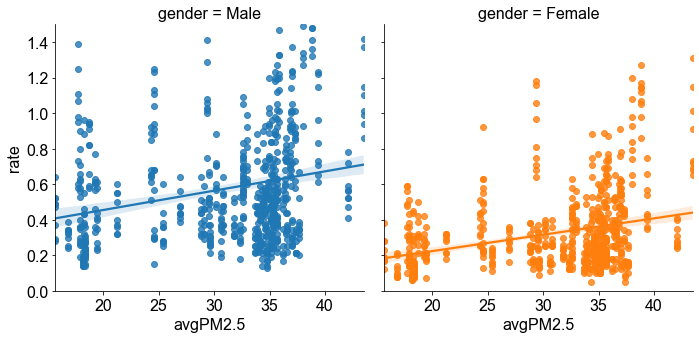

In [412]:
g = sns.lmplot(data=data , x='avgPM2.5', y='rate', hue='gender', col="gender" )
g.set(ylim=(0, 1.5))

plt.savefig(mdataset.report_folder + 'inpat_lung_ln_model.png', dpi=300)

In [413]:
# preparing x and y

x_cols = [ 'income', 'pop_per_avg',   '20-29', 'birth_rate', 'avgPM2.5' ]
y_cols = 'rate'

df = data_noyear[data_noyear['gender']=='Female']
x = df[x_cols] 
y = df[y_cols].values

mod = sm.OLS(y, x)    # Describe model
res = mod.fit()       # Fit model
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.733
Model:                            OLS   Adj. R-squared (uncentered):              0.731
Method:                 Least Squares   F-statistic:                              368.7
Date:                Sun, 06 Jun 2021   Prob (F-statistic):                   1.25e-189
Time:                        11:30:45   Log-Likelihood:                          115.24
No. Observations:                 675   AIC:                                     -220.5
Df Residuals:                     670   BIC:                                     -197.9
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
income         -0.0011      0.028     -0.039      0.969      -0.056       0.054
pop_per_avg     0.1206      0.027      4.425      0.000       0.067       0.174
20-29           0.0028      0.005      0.535      0.593      -0.008       0.013
birth_rate     -0.0010      0.002     -0.579      0.563      -0.004       0.002
avgPM2.5        0.0087      0.001      7.252      0.000       0.006       0.011
==============================================================================
Omnibus:                      204.600   Durbin-Watson:                   1.431
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              524.475
Skew:                           1.554   Prob(JB):                    1.29e-114
Kurtosis:                       5.998   Cond. No.                         160.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [414]:
# preparing x and y

x_cols = [ 'income', 'pop_per_avg',   '20-29', 'birth_rate', 'avgPM2.5' ]
y_cols = 'rate'

df = data_noyear[data_noyear['gender']=='Male']
x = df[x_cols] 
y = df[y_cols].values

mod = sm.OLS(y, x)    # Describe model
res = mod.fit()       # Fit model
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.778
Model:                            OLS   Adj. R-squared (uncentered):              0.776
Method:                 Least Squares   F-statistic:                              468.3
Date:                Sun, 06 Jun 2021   Prob (F-statistic):                   6.88e-216
Time:                        11:30:50   Log-Likelihood:                         -179.53
No. Observations:                 675   AIC:                                      369.1
Df Residuals:                     670   BIC:                                      391.6
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
income          0.1232      0.044      2.817      0.005       0.037       0.209
pop_per_avg     0.1561      0.044      3.586      0.000       0.071       0.242
20-29           0.0003      0.007      0.042      0.966      -0.014       0.015
birth_rate      0.0002      0.002      0.069      0.945      -0.005       0.005
avgPM2.5        0.0125      0.002      6.687      0.000       0.009       0.016
==============================================================================
Omnibus:                      165.524   Durbin-Watson:                   1.650
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              342.460
Skew:                           1.356   Prob(JB):                     4.32e-75
Kurtosis:                       5.195   Cond. No.                         162.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Search Birth Defect

In [165]:
cause = in_pat['disease'].drop_duplicates().reset_index(drop=True)
birth_defect = cause[cause.str.contains('ครรภ์') | cause.str.contains('กำเนิด')| cause.str.contains('แรกเกิด')| cause.str.contains('ทารก')].to_list()
birth_defect = [ 
 'Other pregnancies with abortive outcome (O00-O02, O05-O08)\nการตั้งครรภ์อื่น ๆ ที่สิ้นสุดโดยการแท้ง',
 'Oedema, proteinuria and hypertensive disorders in pregnancy, childbirth and the puerperium (O10-O16)\nการบวม การมีโปรตีนในปัสสาวะ และความดันโลหิตสูงขณะตั้งครรภ์ ระยะคลอด และระยะหลังคลอด',
 'Other maternal care related to fetus and amniotic cavity and possible delivery problems (O30-O43, O47-O48)\nการดูแลมารดาอื่น ๆ ที่มีปัญหาเกี่ยวกับทารกในครรภ์ และถุงน้ำคร่ำ และปัญหาที่อาจจะเกิดได้ในระยะคลอด',
 'Other complications of pregnancy and delivery (O20-O29, O60-O63, O67-O71, O73-O75, O81-O84)\nภาวะแทรกซ้อนอื่น ๆของการตั้งครรภ์ และการคลอด',
 'Fetus and newborn affected by maternal factors and by complications of pregnancy, labour and delivery (P00-P04)\nทารกในครรภ์และแรกเกิดที่ได้รับผลจากปัจจัยทางมารดา และโรคแทรกในระยะตั้งครรภ์ เจ็บครรภ์ และคลอด',
 'Slow fetal growth, fetal malnutrition and disorders related to short gestation and low birth weight (P05-P07)\nทารกในครรภ์โตช้า ทารกในครรภ์ขาดสารอาหาร และความผิดปกติเกี่ยวกับการตั้งครรภ์ระยะสั้น และน้ำหนักทารกแรกเกิดน้อย',
 'Intrauterine hypoxia and birth asphyxia (P20-P21)\nขาดออกซิเจนขณะอยู่ในโพรงมดลูก และภาวะแอสฟิกเซียเมื่อแรกเกิด',
 'Other infections specIfic to the perinatal period (P38-P39)\nการติดเชื้อเฉพาะอื่น ๆ ในระยะปริกำเนิด',
 'Haemolytic disease of fetus and newborn (P55)\nโรคเม็ดเลือดแตกของทารกในครรภ์และแรกเกิด',
 'Other conditions originating in the perinatal period (P08, P29, P50-P54, P56-P96)\nภาวะอื่น ๆ ในระยะปริกำเนิด',
 'Other congenital malformations of the nervous system (Q00-Q04, Q06-Q07)\nความผิดปกติอื่น ๆ แต่กำเนิดของระบบประสาท',
 'Congenital malformation of the circulatory system (Q20-Q28)\nความผิดปกติแต่กำเนิดของระบบไหลเวียนโลหิต',
 'Other congenital malformations of the digestive system (Q38-Q40, Q42-Q45)\nความผิดปกติแต่กำเนิดอื่น ๆ ของระบบย่อยอาหาร',
 'Congenital deformities of hip (Q65)\nความพิการแต่กำเนิดของสะโพก',
 'Congenital deformities of feet (Q66)\nความพิการแต่กำเนิดของเท้า',
 'Other congenital malformations and deformations of the musculoskeletal system (Q67-Q79)\nความผิดปกติและความพิการแต่กำเนิดอื่น ๆ ของระบบกล้ามเนื้อและโครงร่าง',
 'Other congenital malformations (Q10-Q18, Q30-Q34, Q80-Q89)\nความผิดปกติแต่กำเนิดอื่น ๆ']

In [166]:
# global average
region_to_compare = ['Northern Region', 'Northeastern Region', 'Southern Region', 'Central Region']

# pick only three regions
in_pat_3reg = in_pat[in_pat['region'].isin(region_to_compare)]

# calculate the rate by cause_of_dead by year, gender, region
in_pat_3reg = in_pat_3reg.groupby(['year', 'gender', 'disease', 'region' ]).sum()

# calcule rate
in_pat_3reg['rate'] = in_pat_3reg['number']/in_pat_3reg['birth_number']

# calculate average over the years
in_pat_3reg = in_pat_3reg.reset_index()
#in_pat_3reg_global = in_pat_3reg.groupby([ 'gender', 'disease', 'region' ], as_index=False).mean() 

in_pat_3reg_global = in_pat_3reg[in_pat_3reg['disease'].isin(birth_defect)]

In [167]:
# selected provinces in near income range
region_to_compare = ['Northern Region', 'Northeastern Region', 'Southern Region', 'Central Region']

# pick only three regions
in_pat_3reg = in_pat[in_pat['region'].isin(region_to_compare) & in_pat['province'].isin(near_income_list)]

# calculate the rate by cause_of_dead by year, gender, region
in_pat_3reg = in_pat_3reg.groupby(['year', 'gender', 'disease', 'region' ]).sum()

# calcule rate
in_pat_3reg['rate'] = in_pat_3reg['number']/in_pat_3reg['birth_number']

# calculate average over the years
in_pat_3reg = in_pat_3reg.reset_index()
#in_pat_3reg_spec = in_pat_3reg.groupby([ 'gender', 'disease', 'region' ], as_index=False).mean() 

# select only birth defect 
in_pat_3reg_spec = in_pat_3reg[in_pat_3reg['disease'].isin(birth_defect)]

In [168]:
significant_df1 = []
for year, gender, cause in zip(in_pat_3reg_global['year'], in_pat_3reg_global['gender'], in_pat_3reg_global['disease']):
    temp = in_pat_3reg_global[(in_pat_3reg_global['year']==year) & (in_pat_3reg_global['gender']==gender) & (in_pat_3reg_global['disease']==cause )]
    temp = temp.set_index('region')
    if len(temp) == 4:
        row_ne = temp.loc['Northeastern Region']
        row_s = temp.loc['Southern Region']
        z1 = cal_1z_test(row_ne, row_s) 
        
        row_n = temp.loc['Northern Region']
        
        z2 = cal_1z_test(row_n, row_s) 
        
        row_c = temp.loc['Central Region']
      
        z3 = cal_1z_test(row_c, row_s) 
        
        significant_df1.append([year, gender, cause, z1, z2, z3, row_n['rate']/row_s['rate'], row_ne['rate']/row_s['rate'], row_c['rate']/row_s['rate']] )
        
significant_df1 = pd.DataFrame(significant_df1, columns=['year', 'gender', 'disease', 'z_NE', 'z_N', 'z_C', 'ratio_north_south', 'ratio_northeast_south',  'ratio_central_south'])


In [169]:
significant_df2 = []
for year, gender, cause in zip(in_pat_3reg_spec['year'], in_pat_3reg_spec['gender'], in_pat_3reg_spec['disease']):
    temp = in_pat_3reg_spec[(in_pat_3reg_spec['year']==year) & (in_pat_3reg_spec['gender']==gender) & (in_pat_3reg_spec['disease']==cause )]
    temp = temp.set_index('region')
    if len(temp) == 4:
        row_ne = temp.loc['Northeastern Region']
        row_s = temp.loc['Southern Region']
        z1 = cal_1z_test(row_ne, row_s) 
        
        row_n = temp.loc['Northern Region']
        
        z2 = cal_1z_test(row_n, row_s) 
        
        row_c = temp.loc['Central Region']
      
        z3 = cal_1z_test(row_c, row_s) 
        
        significant_df2.append([year, gender, cause, z1, z2, z3]  )
        
significant_df2 = pd.DataFrame(significant_df2, columns=['year', 'gender', 'disease', 'z_NE_spec', 'z_N_spec', 'z_C_spec' ])


In [170]:
significant_df = significant_df1.merge(significant_df2, on=['year','gender','disease'])

In [171]:
significant_avg = significant_df.groupby(['gender','disease'], as_index=False).mean()

In [172]:
significant_avg[significant_avg['ratio_north_south'] > 1]['disease'].unique().tolist()

['Congenital deformities of hip (Q65)\nความพิการแต่กำเนิดของสะโพก',
 'Congenital malformation of the circulatory system (Q20-Q28)\nความผิดปกติแต่กำเนิดของระบบไหลเวียนโลหิต',
 'Intrauterine hypoxia and birth asphyxia (P20-P21)\nขาดออกซิเจนขณะอยู่ในโพรงมดลูก และภาวะแอสฟิกเซียเมื่อแรกเกิด',
 'Other conditions originating in the perinatal period (P08, P29, P50-P54, P56-P96)\nภาวะอื่น ๆ ในระยะปริกำเนิด',
 'Other congenital malformations (Q10-Q18, Q30-Q34, Q80-Q89)\nความผิดปกติแต่กำเนิดอื่น ๆ',
 'Other congenital malformations and deformations of the musculoskeletal system (Q67-Q79)\nความผิดปกติและความพิการแต่กำเนิดอื่น ๆ ของระบบกล้ามเนื้อและโครงร่าง',
 'Other congenital malformations of the digestive system (Q38-Q40, Q42-Q45)\nความผิดปกติแต่กำเนิดอื่น ๆ ของระบบย่อยอาหาร',
 'Other congenital malformations of the nervous system (Q00-Q04, Q06-Q07)\nความผิดปกติอื่น ๆ แต่กำเนิดของระบบประสาท',
 'Other infections specIfic to the perinatal period (P38-P39)\nการติดเชื้อเฉพาะอื่น ๆ ในระยะปริกำเนิด',


In [173]:
inpat_birth_sig = significant_avg[(significant_avg['z_N_spec']> 1.96) & (significant_avg['z_NE_spec']> 1.96) & (significant_avg['z_C_spec']> 1.96)]
inpat_birth_sig['disease'].unique().tolist()

['Haemolytic disease of fetus and newborn (P55)\nโรคเม็ดเลือดแตกของทารกในครรภ์และแรกเกิด',
 'Intrauterine hypoxia and birth asphyxia (P20-P21)\nขาดออกซิเจนขณะอยู่ในโพรงมดลูก และภาวะแอสฟิกเซียเมื่อแรกเกิด',
 'Other conditions originating in the perinatal period (P08, P29, P50-P54, P56-P96)\nภาวะอื่น ๆ ในระยะปริกำเนิด',
 'Other congenital malformations (Q10-Q18, Q30-Q34, Q80-Q89)\nความผิดปกติแต่กำเนิดอื่น ๆ',
 'Other congenital malformations and deformations of the musculoskeletal system (Q67-Q79)\nความผิดปกติและความพิการแต่กำเนิดอื่น ๆ ของระบบกล้ามเนื้อและโครงร่าง',
 'Other congenital malformations of the digestive system (Q38-Q40, Q42-Q45)\nความผิดปกติแต่กำเนิดอื่น ๆ ของระบบย่อยอาหาร',
 'Other congenital malformations of the nervous system (Q00-Q04, Q06-Q07)\nความผิดปกติอื่น ๆ แต่กำเนิดของระบบประสาท',
 'Other infections specIfic to the perinatal period (P38-P39)\nการติดเชื้อเฉพาะอื่น ๆ ในระยะปริกำเนิด',
 'Other pregnancies with abortive outcome (O00-O02, O05-O08)\nการตั้งครรภ์อื่น ๆ ที

In [176]:
inpat_birth_sig.to_csv(mdataset.health_folder  + 'process/' + 'inpat_birth_defect.csv', index=False, encoding='utf-8')

In [175]:
inpat_birth_sig[inpat_birth_sig['disease'].isin(['Haemolytic disease of fetus and newborn (P55)\nโรคเม็ดเลือดแตกของทารกในครรภ์และแรกเกิด',
 'Other conditions originating in the perinatal period (P08, P29, P50-P54, P56-P96)\nภาวะอื่น ๆ ในระยะปริกำเนิด',
 'Other congenital malformations (Q10-Q18, Q30-Q34, Q80-Q89)\nความผิดปกติแต่กำเนิดอื่น ๆ',
 'Other pregnancies with abortive outcome (O00-O02, O05-O08)\nการตั้งครรภ์อื่น ๆ ที่สิ้นสุดโดยการแท้ง'])]

,gender,disease,year,z_NE,z_N,z_C,ratio_north_south,ratio_northeast_south,ratio_central_south,z_NE_spec,z_N_spec,z_C_spec
4,Female,Haemolytic disease of fetus and newborn (P55)\...,2012.727273,24.365610,-8.733381,25.128026,0.925125,1.281418,1.310414,19.350587,13.935483,40.773347
8,Female,Other conditions originating in the perinatal ...,2012.727273,266.326318,216.204502,107.577207,1.578406,1.676735,1.263399,138.833768,129.398077,98.274088
9,Female,"Other congenital malformations (Q10-Q18, Q30-Q...",2012.727273,4.562897,12.168843,-22.561935,1.157979,1.053166,0.762427,29.125561,28.167823,8.033480
15,Female,Other pregnancies with abortive outcome (O00-O...,2012.727273,-140.831689,-55.109038,-173.093127,0.866207,0.709879,0.614523,24.426342,60.970438,42.457367
21,Male,Haemolytic disease of fetus and newborn (P55)\...,2012.727273,22.373217,-9.326228,26.911152,0.928711,1.292654,1.369625,18.446754,13.097014,41.398483
25,Male,Other conditions originating in the perinatal ...,2012.727273,285.387910,251.175266,118.762341,1.634647,1.673471,1.272994,146.275201,146.216257,102.804765
26,Male,"Other congenital malformations (Q10-Q18, Q30-Q...",2012.727273,12.462524,20.449501,-17.072334,1.286327,1.157953,0.810070,33.008356,32.328208,11.683566


In [106]:
significant_avg[significant_avg['disease'].isin(['Congenital deformities of hip (Q65)\nความพิการแต่กำเนิดของสะโพก',
 'Other congenital malformations of the digestive system (Q38-Q40, Q42-Q45)\nความผิดปกติแต่กำเนิดอื่น ๆ ของระบบย่อยอาหาร',
 'Other congenital malformations of the nervous system (Q00-Q04, Q06-Q07)\nความผิดปกติอื่น ๆ แต่กำเนิดของระบบประสาท',
 'Other conditions originating in the perinatal period (P08, P29, P50-P54, P56-P96)\nภาวะอื่น ๆ ในระยะปริกำเนิด',
 'Other congenital malformations and deformations of the musculoskeletal system (Q67-Q79)\nความผิดปกติและความพิการแต่กำเนิดอื่น ๆ ของระบบกล้ามเนื้อและโครงร่าง'])]

,gender,disease,year,z_NE,z_N,z_C,ratio_north_south,ratio_northeast_south,ratio_central_south,z_NE_spec,z_N_spec,z_C_spec
1,Female,Congenital deformities of hip (Q65)\nความพิการ...,2012.500000,-0.207854,-0.270470,-1.476543,1.062832,1.123069,0.606232,-0.776038,1.571441,-0.918018
8,Female,Other conditions originating in the perinatal ...,2012.727273,10.352102,-0.965765,5.404155,0.988691,1.156234,1.088723,-3.444969,-10.403323,-0.042650
10,Female,Other congenital malformations and deformation...,2012.727273,-0.381376,-0.445119,-2.948039,0.957886,0.974917,0.730791,-1.225034,2.104230,-1.609153
11,Female,Other congenital malformations of the digestiv...,2012.727273,-2.446309,-1.692092,4.433207,1.037870,0.901686,1.418402,-6.533257,1.605861,-0.974173
12,Female,Other congenital malformations of the nervous ...,2012.727273,-0.859456,0.269661,-0.505386,1.083302,0.891783,0.934002,-1.544603,0.956582,-1.129397
18,Male,Congenital deformities of hip (Q65)\nความพิการ...,2012.500000,-0.068982,-0.665720,-1.186664,0.713431,1.037227,0.530503,-0.144048,1.059983,-0.645116
25,Male,Other conditions originating in the perinatal ...,2012.727273,9.055654,1.789552,6.969262,1.028054,1.123856,1.103567,-5.482895,-9.729976,0.588077
27,Male,Other congenital malformations and deformation...,2012.727273,-0.397996,-0.106491,-2.530668,1.001812,0.971466,0.777295,-1.697294,2.052717,-1.244227
28,Male,Other congenital malformations of the digestiv...,2012.727273,-3.474699,-2.772813,4.819090,0.960364,0.873040,1.353196,-7.719477,1.701684,-0.400187
29,Male,Other congenital malformations of the nervous ...,2012.727273,-0.457134,1.247204,-0.585487,1.282518,0.949537,0.925558,-1.869519,1.251424,-1.273187


## Visualize Birth Defect data

In [371]:
dis = 'Other conditions originating in the perinatal period (P08, P29, P50-P54, P56-P96)\nภาวะอื่น ๆ ในระยะปริกำเนิด'

In [372]:
# calculate the rate by cause_of_in_pat by year, gender, region
in_pat_reg = in_pat.groupby(['year', 'gender', 'disease', 'region' ]).sum()

# calcule rate
in_pat_reg['rate'] = in_pat_reg['number']/in_pat_reg['birth_number']

# reset index
in_pat_reg = in_pat_reg.reset_index()

one_disease = in_pat_reg[in_pat_reg['disease'] == dis]

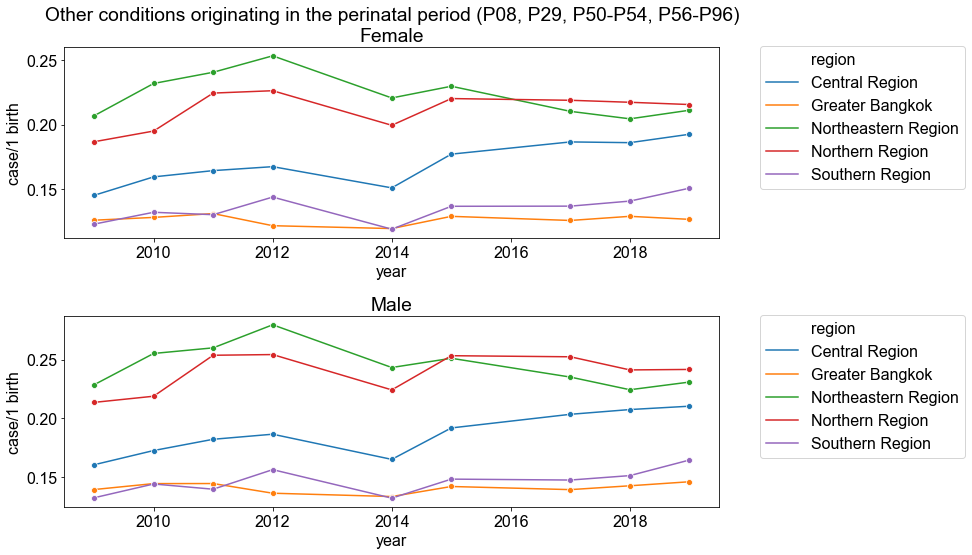

In [374]:
_, ax = plt.subplots(2,1, figsize=(14,8))

df = one_disease[one_disease['gender']=='Female']
sns.lineplot(data=df, x='year', y='rate', hue='region', ax=ax[0], marker='o')

df = one_disease[one_disease['gender']=='Male']
sns.lineplot(data=df, x='year', y='rate', hue='region', ax=ax[1], marker='o')

for a, t in zip(ax, [dis.split('\n')[0] + '\nFemale', 'Male']):
    a.set_title(t)
    a.legend(bbox_to_anchor=(1.05, 1.05))
    a.set_ylabel('case/1 birth')
    
plt.tight_layout()
plt.savefig(mdataset.report_folder + 'inpat_birth_years.png', dpi=300)

In [377]:
# select year 
temp = in_pat[in_pat['year'].isin(np.arange(2015, 2020))]
mean_rate = temp.groupby(['year', 'gender', 'disease', 'province' ]).sum()

# calcule rate
mean_rate['rate'] = mean_rate['number']/mean_rate['birth_number']*1000

# reset index
mean_rate = mean_rate.reset_index()
mean_rate = mean_rate[mean_rate['disease'] == dis]

# average of the rate
std_rate = mean_rate.groupby([ 'gender', 'disease', 'province'], as_index=False).std()

mean_rate = mean_rate.groupby([ 'gender', 'disease', 'province'], as_index=False).mean()

mean_rate = mean_rate.merge(std_rate, on=[ 'gender', 'disease', 'province'], suffixes=('', '_std'))

# create a map of pollution by merging with the shape file 
plot_map = mdataset.prov_map.merge(mean_rate, on='province', how='left')

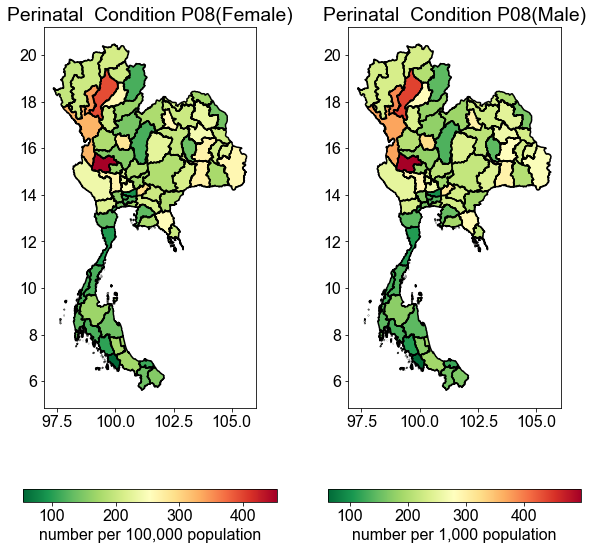

In [378]:
_, ax = plt.subplots(1, 2, figsize=(10,10))

df = plot_map[plot_map['gender']=='Female']

df.plot(column='rate',
           ax=ax[0],legend=True,
           legend_kwds={'label': "number per 100,000 population",
                       'orientation': "horizontal"},  cmap='RdYlGn_r',
             missing_kwds={
         "color": "lightgrey",
         "edgecolor": "red",
            "hatch": "///",
           "label": "Missing values" },)

 
df.boundary.plot(ax=ax[0], color='black')

df = plot_map[plot_map['gender']=='Male']

df.plot(column='rate',
           ax=ax[1],legend=True,
           legend_kwds={'label': "number per 1,000 population",
                       'orientation': "horizontal"},  cmap='RdYlGn_r',
             missing_kwds={
         "color": "lightgrey",
         "edgecolor": "red",
            "hatch": "///",
           "label": "Missing values" },)

 
df.boundary.plot(ax=ax[1], color='black')

ax[0].set_title("Perinatal Condition P08(Female)")
ax[1].set_title("Perinatal Condition P08(Male)");

plt.savefig(mdataset.report_folder + 'inpat_birth_map.png', dpi=300)

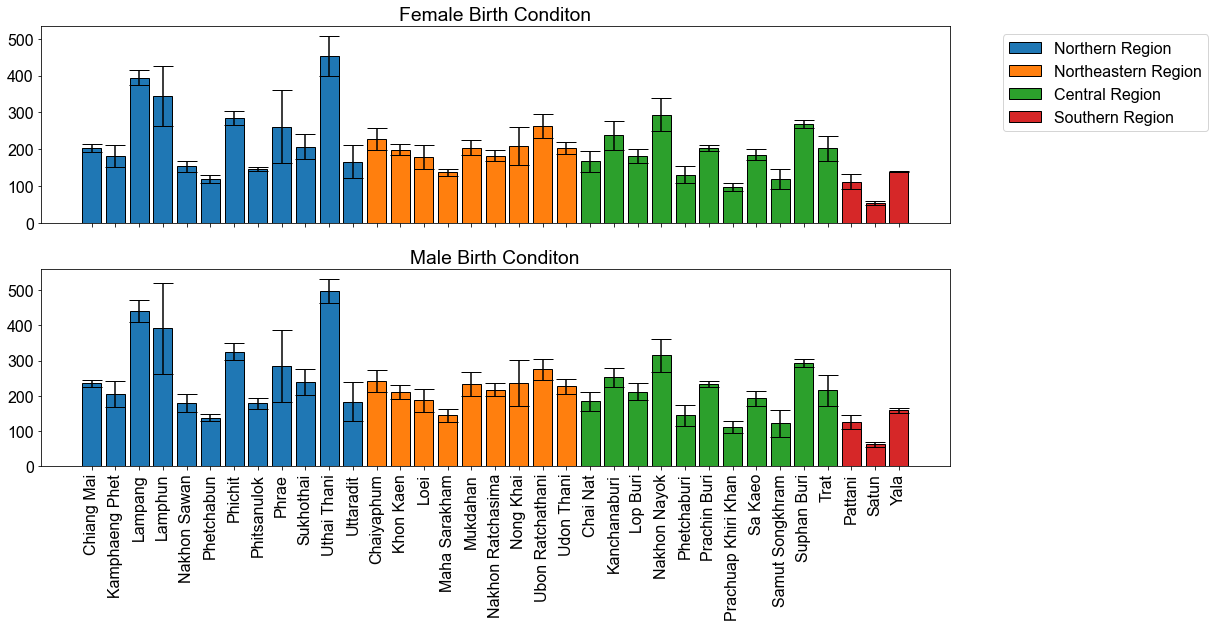

In [379]:
fig, ax = plt.subplots(2,1, figsize=(14, 9), sharex=True)
#ax.bar(pm10_short_list['province'], pm10_short_list['avgPM10'])


for region in region_list:
    # select province
    prov_in_region = provinces[provinces['region'] == region]['province'].to_list()
    # select only province near Chiang Mai
    # use province_list to keep the bar plot in the same order

    prov_in_region = [s for s in near_income_list if s in prov_in_region]
    df = mean_rate[mean_rate['province'].isin(prov_in_region) & (mean_rate['gender'] == 'Female')]
     
    if len(df) > 0:
        ax[0].bar(df['province'], df['rate'], yerr=df['rate_std'], label=region, edgecolor='black', capsize=10)
        
         
    df = mean_rate[mean_rate['province'].isin(prov_in_region) & (mean_rate['gender'] == 'Male')]
     
    if len(df) > 0:
        ax[1].bar(df['province'], df['rate'], yerr=df['rate_std'], label=region, edgecolor='black', capsize=10)
        
        
# highlight Chiang Mai
#df = dead_male_short.loc[['Chiang Mai']]
#ax[0].bar(df.index, df['lung_dead'], color='magenta', label='Chiang Mai', edgecolor='black')

#df = dead_female_short.loc[['Chiang Mai']]
#ax[1].bar(df.index, df['lung_dead'], color='magenta', label='Chiang Mai', edgecolor='black')

 
ax[0].legend(bbox_to_anchor=(1.05, 1.0))
plt.draw()
ax[0].set_title('Female Birth Conditon')
ax[1].set_title('Male Birth Conditon')

ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90);

plt.tight_layout()
plt.savefig(mdataset.report_folder + 'inpat_birth_15-20_bar.png', dpi=300)

## Modeling Birth Defect

In [447]:
population = pd.read_csv(mdataset.health_folder  + 'process/pop_prov.csv')  
population = population.drop(['province_th', 'gender_th'], axis=1)

pop = population.melt(id_vars=['province', 'gender'], var_name='year', value_name='pop')
pop['year'] = pop['year'].astype(int)
in_pat = pd.read_csv(mdataset.health_folder + 'process/in_patient_2007_2019.csv').dropna()
in_pat['year'] = in_pat['year'].astype(int)
# in_pat = in_pat[~in_pat['year'].isin([2013, 2016])]
# add population 
in_pat = in_pat.merge(pop, on=['province', 'gender', 'year'], how='left')

# add birth rate
birth_rate = pd.read_csv(mdataset.health_folder  + 'process/birth_prov_w_gender.csv')
birth_rate = birth_rate.rename(columns={'number':'birth_number'})
birth_rate['year'] = birth_rate['year'].astype(int)

in_pat = in_pat.merge(birth_rate, on=['province',  'year', 'gender'], how='left')

# load provinces & region information 
provinces = mdataset.prov_map[['region', 'province']]

region_list = ['Northern Region', 'Northeastern Region', 'Central Region','Greater Bangkok','Southern Region']

# add region
in_pat = in_pat.merge(provinces, on='province', how='left')

# remove use number and remove total in gender 
in_pat = in_pat[(in_pat['number_type'] == 'number') & (in_pat['gender'].isin(['Male', 'Female'])) ]
in_pat = in_pat[~in_pat['region'].isna()]

In [448]:
dis_list = ['Haemolytic disease of fetus and newborn (P55)\nโรคเม็ดเลือดแตกของทารกในครรภ์และแรกเกิด',
 'Intrauterine hypoxia and birth asphyxia (P20-P21)\nขาดออกซิเจนขณะอยู่ในโพรงมดลูก และภาวะแอสฟิกเซียเมื่อแรกเกิด',
 'Other conditions originating in the perinatal period (P08, P29, P50-P54, P56-P96)\nภาวะอื่น ๆ ในระยะปริกำเนิด',
 'Other congenital malformations (Q10-Q18, Q30-Q34, Q80-Q89)\nความผิดปกติแต่กำเนิดอื่น ๆ',
 'Other congenital malformations and deformations of the musculoskeletal system (Q67-Q79)\nความผิดปกติและความพิการแต่กำเนิดอื่น ๆ ของระบบกล้ามเนื้อและโครงร่าง',
 'Other congenital malformations of the digestive system (Q38-Q40, Q42-Q45)\nความผิดปกติแต่กำเนิดอื่น ๆ ของระบบย่อยอาหาร',
 'Other congenital malformations of the nervous system (Q00-Q04, Q06-Q07)\nความผิดปกติอื่น ๆ แต่กำเนิดของระบบประสาท',
 'Other infections specIfic to the perinatal period (P38-P39)\nการติดเชื้อเฉพาะอื่น ๆ ในระยะปริกำเนิด',
 'Other pregnancies with abortive outcome (O00-O02, O05-O08)\nการตั้งครรภ์อื่น ๆ ที่สิ้นสุดโดยการแท้ง',
 'Congenital deformities of hip (Q65)\nความพิการแต่กำเนิดของสะโพก',
 'Slow fetal growth, fetal malnutrition and disorders related to short gestation and low birth weight (P05-P07)\nทารกในครรภ์โตช้า ทารกในครรภ์ขาดสารอาหาร และความผิดปกติเกี่ยวกับการตั้งครรภ์ระยะสั้น และน้ำหนักทารกแรกเกิดน้อย']

In [449]:
dis = dis_list[2]
print(dis)
in_pat_dis = in_pat[in_pat['disease'] == dis]
in_pat_dis['rate'] = (in_pat_dis['number']/in_pat_dis['pop']*1000).round(2)
in_pat_dis['birth_rate'] = (in_pat_dis['number']/in_pat_dis['birth_number']*1000).round()
    
data  = build_data(in_pat_dis, avg_pm24_prov_noyear)

# remove bkk
#data = data [data['province'] != 'Bangkok']
data.head()

Other conditions originating in the perinatal period (P08, P29, P50-P54, P56-P96)
ภาวะอื่น ๆ ในระยะปริกำเนิด
data shape (1350, 26)


,gender,province,year,pop,birth_number,region,rate,birth_rate,avgPM2.5,income,...,40-49,50-59,60-69,70-79,80-89,90+,pop_per_avg,pop_per_sum,smoke_rate,lit_rate
0,Male,Krabi,2011,218708.0,3807.0,Southern Region,1.13,65.0,17.85,1.60,...,12.51,7.86,3.75,2.41,0.86,0.11,0.20,0.24,0.41,0.51
1,Male,Chumphon,2011,244542.0,3392.0,Southern Region,1.17,84.0,21.20,1.34,...,14.11,9.70,5.27,3.35,1.26,0.15,0.22,0.27,0.41,0.51
2,Male,Trang,2011,307422.0,4579.0,Southern Region,1.65,111.0,15.67,1.74,...,13.02,9.12,4.56,2.90,1.03,0.12,0.27,0.33,0.41,0.51
3,Male,Nakhon Si Thammarat,2011,757150.0,9805.0,Southern Region,1.73,134.0,19.20,1.44,...,12.79,8.89,5.31,3.36,1.24,0.18,0.68,0.82,0.41,0.51
4,Male,Narathiwat,2011,370019.0,7186.0,Southern Region,4.17,215.0,18.33,0.81,...,11.12,7.22,4.13,2.32,0.89,0.21,0.33,0.40,0.41,0.51


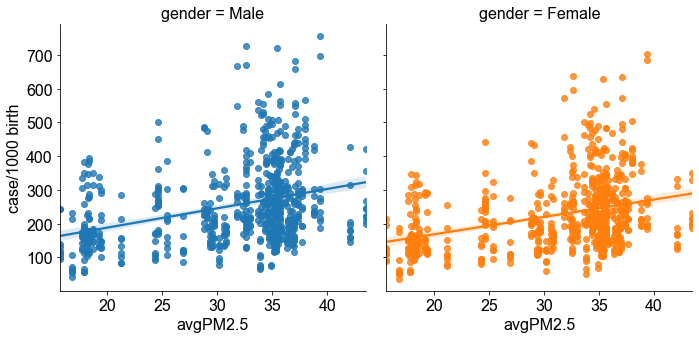

In [450]:
g = sns.lmplot(data=data , x='avgPM2.5', y='birth_rate', hue='gender', col="gender" )
#g.set(ylim=(0, 1.5))
g.axes[0,0].set_ylabel('case/1000 birth')
plt.savefig(mdataset.report_folder + 'inpat_birth_ln_model.png', dpi=300)

In [451]:
# preparing x and y

x_cols = [ 'income', 'pop_per_avg',   '20-29', 'birth_rate', 'avgPM2.5' ]
y_cols = 'rate'

df = data_noyear[data_noyear['gender']=='Female']
x = df[x_cols] 
y = df[y_cols].values

mod = sm.OLS(y, x)    # Describe model
res = mod.fit()       # Fit model
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.733
Model:                            OLS   Adj. R-squared (uncentered):              0.731
Method:                 Least Squares   F-statistic:                              368.7
Date:                Sun, 06 Jun 2021   Prob (F-statistic):                   1.25e-189
Time:                        11:42:29   Log-Likelihood:                          115.24
No. Observations:                 675   AIC:                                     -220.5
Df Residuals:                     670   BIC:                                     -197.9
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
income         -0.0011      0.028     -0.039      0.969      -0.056       0.054
pop_per_avg     0.1206      0.027      4.425      0.000       0.067       0.174
20-29           0.0028      0.005      0.535      0.593      -0.008       0.013
birth_rate     -0.0010      0.002     -0.579      0.563      -0.004       0.002
avgPM2.5        0.0087      0.001      7.252      0.000       0.006       0.011
==============================================================================
Omnibus:                      204.600   Durbin-Watson:                   1.431
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              524.475
Skew:                           1.554   Prob(JB):                    1.29e-114
Kurtosis:                       5.998   Cond. No.                         160.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [452]:
# preparing x and y

x_cols = [ 'income', 'pop_per_avg',   '20-29', 'birth_rate', 'avgPM2.5' ]
y_cols = 'rate'

df = data_noyear[data_noyear['gender']=='Male']
x = df[x_cols] 
y = df[y_cols].values

mod = sm.OLS(y, x)    # Describe model
res = mod.fit()       # Fit model
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.778
Model:                            OLS   Adj. R-squared (uncentered):              0.776
Method:                 Least Squares   F-statistic:                              468.3
Date:                Sun, 06 Jun 2021   Prob (F-statistic):                   6.88e-216
Time:                        11:42:30   Log-Likelihood:                         -179.53
No. Observations:                 675   AIC:                                      369.1
Df Residuals:                     670   BIC:                                      391.6
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
income          0.1232      0.044      2.817      0.005       0.037       0.209
pop_per_avg     0.1561      0.044      3.586      0.000       0.071       0.242
20-29           0.0003      0.007      0.042      0.966      -0.014       0.015
birth_rate      0.0002      0.002      0.069      0.945      -0.005       0.005
avgPM2.5        0.0125      0.002      6.687      0.000       0.009       0.016
==============================================================================
Omnibus:                      165.524   Durbin-Watson:                   1.650
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              342.460
Skew:                           1.356   Prob(JB):                     4.32e-75
Kurtosis:                       5.195   Cond. No.                         162.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Out Patient

In [287]:
population = pd.read_csv(mdataset.health_folder  + 'process/pop_prov.csv')  
population = population.drop(['province_th', 'gender_th'], axis=1)

pop = population.melt(id_vars=['province', 'gender'], var_name='year', value_name='pop')
pop['year'] = pop['year'].astype(int)
out_pat = pd.read_csv(mdataset.health_folder + 'process/out_patient_2007_2019.csv').dropna()
out_pat['gender'] = 'Total'
# add population 
out_pat = out_pat.merge(pop, on=['province', 'gender', 'year'], how='left')

# add birth rate

birth_rate = pd.read_csv(mdataset.health_folder  + 'process/birth_prov.csv')
birth_rate = birth_rate.rename(columns={'number':'birth_number'})
birth_rate['year'] = birth_rate['year'].astype(int)

out_pat = out_pat.merge(birth_rate, on=['province',  'year'], how='left')

# load provinces & region information 
provinces = mdataset.prov_map[['region', 'province']]

region_list = ['Northern Region', 'Northeastern Region', 'Central Region','Greater Bangkok','Southern Region']

# add region
out_pat = out_pat.merge(provinces, on='province', how='left')

In [178]:
out_pat['disease'].unique().shape

(21,)

In [12]:
birth_defect = ['ภาวะแทรกในการตั้งครรภ์ การคลอด และระยะหลังคลอด (O00-O99) ยกเว้น (080-084)',
       'ภาวะผิดปกติของทารกที่เกิดขึ้นในระยะปริกำเนิด (อายุครรภ์ 22 สัปดาห์ขึ้นไปจนถึง 7 วันหลังคลอด) (P00-P96) Certain conditions originating in the perinatal period ',
       'รูปร่างผิดปกติแต่กำเนิด  การพิการจนผิดรูปแต่กำเนิดและโครโมโซม  ผิดปกติ (Q00-Q99) Congenital malformations, deformations and chromosomal abnormalities']

## Compare Region

In [168]:
region_to_compare = ['Northern Region', 'Northeastern Region', 'Southern Region', 'Central Region']

# pick only three regions
out_pat_3reg = out_pat[out_pat['region'].isin(region_to_compare)]

# calculate the rate by cause_of_dead by year, gender, region
out_pat_3reg = out_pat_3reg.groupby(['year', 'gender', 'disease', 'region' ]).sum()

# calcule rate
out_pat_3reg['rate'] = out_pat_3reg['number']/out_pat_3reg['pop']

In [169]:
# calculate average over the years
out_pat_3reg = out_pat_3reg.reset_index()
out_pat_3reg = out_pat_3reg.groupby([ 'gender', 'disease', 'region' ], as_index=False).mean() 

In [170]:
out_pat_3reg

,gender,disease,region,year,code,number,pop,rate
0,Total,"การเป็นพิษและผลที่ตามมา (X40-X49, X60-X69, X85...",Central Region,2011.222222,836.000000,7.788990e+04,2.552825e+07,0.003095
1,Total,"การเป็นพิษและผลที่ตามมา (X40-X49, X60-X69, X85...",Northeastern Region,2011.222222,705.111111,6.717051e+04,4.135143e+07,0.001654
2,Total,"การเป็นพิษและผลที่ตามมา (X40-X49, X60-X69, X85...",Northern Region,2011.222222,646.000000,1.325694e+05,2.370353e+07,0.005611
3,Total,"การเป็นพิษและผลที่ตามมา (X40-X49, X60-X69, X85...",Southern Region,2011.222222,523.555556,2.671060e+04,1.774826e+07,0.001546
4,Total,ภาวะผิดปกติของทารกที่เกิดขึ้นในระยะปริกำเนิด (...,Central Region,2011.222222,704.000000,3.975607e+04,2.552825e+07,0.001554
...,...,...,...,...,...,...,...,...
79,Total,โรคเกี่ยวกับต่อมไร้ท่อ โภชนการ และเมตะบอลิสัม(...,Southern Region,2011.222222,110.222222,2.587803e+06,1.774826e+07,0.143853
80,Total,โรคเลือดและอวัยวะสร้างเลือด และความผิดปกติเกี่...,Central Region,2011.222222,132.000000,2.586651e+05,2.552825e+07,0.010095
81,Total,โรคเลือดและอวัยวะสร้างเลือด และความผิดปกติเกี่...,Northeastern Region,2011.222222,111.333333,4.155870e+05,4.135143e+07,0.009995
82,Total,โรคเลือดและอวัยวะสร้างเลือด และความผิดปกติเกี่...,Northern Region,2011.222222,102.000000,2.655913e+05,2.370353e+07,0.011194


In [171]:
significant_df1 = []
for gender, cause in zip(out_pat_3reg['gender'], out_pat_3reg['disease']):
    temp = out_pat_3reg[(out_pat_3reg['gender']==gender) & (out_pat_3reg['disease']==cause )]
    temp = temp.set_index('region')
    if len(temp) == 4:
        row_ne = temp.loc['Northeastern Region']
        row_s = temp.loc['Southern Region']
        z1 = cal_1z_test(row_ne, row_s) 
        
        row_n = temp.loc['Northern Region']
        
        z2 = cal_1z_test(row_n, row_s) 
        
        row_c = temp.loc['Central Region']
      
        z3 = cal_1z_test(row_c, row_s) 
        
        if (z1 >= 1.96) & (z2>= 1.96) & (z3>= 1.96):
            significant_df1.append([gender, cause, z1, z2, z3, row_n['rate']/row_s['rate'], row_ne['rate']/row_s['rate'], row_c['rate']/row_s['rate']] )
        
significant_df1 = pd.DataFrame(significant_df1, columns=['gender', 'disease', 'z_NE', 'z_N', 'z_C', 'ratio_north_south', 'ratio_northeast_south',  'ratio_central_south'])

# z2 should be more than z1
significant_df1['north_higher_than_ne_c'] =  (significant_df1['z_N'] > significant_df1['z_NE']) & (significant_df1['z_N'] > significant_df1['z_C']) 
significant_df1 = significant_df1[significant_df1['north_higher_than_ne_c'] == True]
significant_df1 = significant_df1.drop_duplicates()

In [172]:
significant_df1['disease'].unique()

array(['การเป็นพิษและผลที่ตามมา (X40-X49, X60-X69, X85-X90) Poisoning, toxic effect, and their sequelae',
       'สาเหตุจากภายนอกอื่นๆ ที่ทำให้ป่วยหรือตาย (W00-W99, X00-X19, X20-X29, X30-X39, X50-X59, X70-X84, X91-X99, Y00-Y09, Y20-Y36, Y40-Y84, Y86-Y89) Other external causes of morbidity and mortality (eg: accidents, injuries, intentional self-harm, assault, animals and plants, complications of medical and surgical care and other unspecified causes)',
       'เนื้องอก (รวมมะเร็ง) (C00-C97, D00-D48) Neoplasms',
       'โรคระบบกล้ามเนื้อ รวมโครงร่าง และเนื้อยึดเสริม (M00-M99) Diseases of the musculoskeletal system and connective tissue',
       'โรคระบบประสาท (G00-G99) Diseases of the mervous system',
       'โรคระบบย่อยอาหาร รวมโรคในช่องปาก (K00-K93) Diseases of the digestive system',
       'โรคระบบสืบพันธุ์ร่วมปัสสาวะ (N00-N99) Diseases of the genitourinary system',
       'โรคเกี่ยวกับต่อมไร้ท่อ โภชนการ และเมตะบอลิสัม(E00-E90) Endocrine, mutritional and metabolic diseases',
       '

In [173]:
remove_list = ['การเป็นพิษและผลที่ตามมา (X40-X49, X60-X69, X85-X90) Poisoning, toxic effect, and their sequelae',       'สาเหตุจากภายนอกอื่นๆ ที่ทำให้ป่วยหรือตาย (W00-W99, X00-X19, X20-X29, X30-X39, X50-X59, X70-X84, X91-X99, Y00-Y09, Y20-Y36, Y40-Y84, Y86-Y89) Other external causes of morbidity and mortality (eg: accidents, injuries, intentional self-harm, assault, animals and plants, complications of medical and surgical care and other unspecified causes)',
       'โรคติดเชื้อและปรสิต (A00-A99, B00-B99 )Certain infectious and parasitic diseases',
       'โรคระบบกล้ามเนื้อ รวมโครงร่าง และเนื้อยึดเสริม (M00-M99) Diseases of the musculoskeletal system and connective tissue',
        'โรคระบบย่อยอาหาร รวมโรคในช่องปาก (K00-K93) Diseases of the digestive system',
       'โรคระบบสืบพันธุ์ร่วมปัสสาวะ (N00-N99) Diseases of the genitourinary system',
       'โรคเกี่ยวกับต่อมไร้ท่อ โภชนการ และเมตะบอลิสัม(E00-E90) Endocrine, mutritional and metabolic diseases' ]

significant_df1 = significant_df1[~significant_df1['disease'].isin(remove_list)]

 ## Compare Provinces with similar income

In [174]:
region_to_compare = ['Northern Region', 'Northeastern Region', 'Southern Region', 'Central Region']

# pick only three regions
out_pat_3reg = out_pat[out_pat['region'].isin(region_to_compare) & out_pat['province'].isin(near_income_list) ]

# calculate the rate by cause_of_dead by year, gender, region
out_pat_3reg = out_pat_3reg.groupby(['year', 'gender', 'disease', 'region' ]).sum()

# calcule rate
out_pat_3reg['rate'] = out_pat_3reg['number']/out_pat_3reg['pop']

In [175]:
# calculate average over the years
out_pat_3reg = out_pat_3reg.reset_index()
out_pat_3reg = out_pat_3reg.groupby([ 'gender', 'disease', 'region' ], as_index=False).mean() 

In [176]:
significant_df2 = []
for gender, cause in zip(out_pat_3reg['gender'], out_pat_3reg['disease']):
    temp = out_pat_3reg[(out_pat_3reg['gender']==gender) & (out_pat_3reg['disease']==cause )]
    temp = temp.set_index('region')
    if len(temp) == 4:
        row_ne = temp.loc['Northeastern Region']
        row_s = temp.loc['Southern Region']
        z1 = cal_1z_test(row_ne, row_s) 
        
        row_n = temp.loc['Northern Region']
        
        z2 = cal_1z_test(row_n, row_s) 
        
        row_c = temp.loc['Central Region']
      
        z3 = cal_1z_test(row_c, row_s) 
        
        if (z1 >= 1.96) & (z2>= 1.96) & (z3>= 1.96):
            significant_df2.append([gender, cause, z1, z2, z3 ] )
        
significant_df2 = pd.DataFrame(significant_df2, columns=['gender', 'disease', 'z_NE_income', 'z_N_income', 'z_C_income' ])

significant_df2 = significant_df2.drop_duplicates()

In [177]:
remove_list = ['การเป็นพิษและผลที่ตามมา (X40-X49, X60-X69, X85-X90) Poisoning, toxic effect, and their sequelae',       'สาเหตุจากภายนอกอื่นๆ ที่ทำให้ป่วยหรือตาย (W00-W99, X00-X19, X20-X29, X30-X39, X50-X59, X70-X84, X91-X99, Y00-Y09, Y20-Y36, Y40-Y84, Y86-Y89) Other external causes of morbidity and mortality (eg: accidents, injuries, intentional self-harm, assault, animals and plants, complications of medical and surgical care and other unspecified causes)',
       'โรคติดเชื้อและปรสิต (A00-A99, B00-B99 )Certain infectious and parasitic diseases',
       'โรคระบบกล้ามเนื้อ รวมโครงร่าง และเนื้อยึดเสริม (M00-M99) Diseases of the musculoskeletal system and connective tissue',
        'โรคระบบย่อยอาหาร รวมโรคในช่องปาก (K00-K93) Diseases of the digestive system',
       'โรคระบบสืบพันธุ์ร่วมปัสสาวะ (N00-N99) Diseases of the genitourinary system',
       'โรคเกี่ยวกับต่อมไร้ท่อ โภชนการ และเมตะบอลิสัม(E00-E90) Endocrine, mutritional and metabolic diseases' ]

significant_df2 = significant_df2[~significant_df2['disease'].isin(remove_list)]

In [178]:
significant_df1.shape

(3, 9)

In [179]:
significant_df2.shape

(9, 5)

In [180]:
significant_df_merge = significant_df1.merge(significant_df2, on=['gender', 'disease'], how='inner')
significant_df_merge.shape

(3, 12)

In [181]:
significant_df_merge.to_csv(mdataset.health_folder  + 'process/' + 'out_patient_narrow.csv', index=False, encoding='utf-8')

In [182]:
significant_df_merge

,gender,disease,z_NE,z_N,z_C,ratio_north_south,ratio_northeast_south,ratio_central_south,north_higher_than_ne_c,z_NE_income,z_N_income,z_C_income
0,Total,"เนื้องอก (รวมมะเร็ง) (C00-C97, D00-D48) Neoplasms",96.180588,175.703333,129.085686,1.696929,1.323174,1.483509,True,89.783196,147.929569,110.074564
1,Total,โรคระบบประสาท (G00-G99) Diseases of the mervou...,21.354010,233.173837,224.021617,1.585392,1.042707,1.551883,True,85.582229,175.371400,186.856497
2,Total,โรคเลือดและอวัยวะสร้างเลือด และความผิดปกติเกี่...,76.757368,106.710433,74.489633,1.417447,1.265658,1.278217,True,86.759639,103.600696,65.540236


## Search for Birth Defect

In [179]:
birth_defect = ['ภาวะแทรกในการตั้งครรภ์ การคลอด และระยะหลังคลอด (O00-O99) ยกเว้น (080-084)',
       'ภาวะผิดปกติของทารกที่เกิดขึ้นในระยะปริกำเนิด (อายุครรภ์ 22 สัปดาห์ขึ้นไปจนถึง 7 วันหลังคลอด) (P00-P96) Certain conditions originating in the perinatal period ',
       'รูปร่างผิดปกติแต่กำเนิด  การพิการจนผิดรูปแต่กำเนิดและโครโมโซม  ผิดปกติ (Q00-Q99) Congenital malformations, deformations and chromosomal abnormalities']

In [180]:
# global average
region_to_compare = ['Northern Region', 'Northeastern Region', 'Southern Region', 'Central Region']

# pick only three regions
out_pat_3reg = out_pat[out_pat['region'].isin(region_to_compare)]
out_pat_3reg = out_pat_3reg.dropna()

# calculate the rate by cause_of_dead by year, gender, region
out_pat_3reg = out_pat_3reg.groupby(['year', 'gender', 'disease', 'region' ]).sum()

# calcule rate
out_pat_3reg['rate'] = out_pat_3reg['number']/out_pat_3reg['birth_number']

# calculate average over the years
out_pat_3reg = out_pat_3reg.reset_index()
#out_pat_3reg_global = out_pat_3reg.groupby([ 'gender', 'disease', 'region' ], as_index=False).mean() 

out_pat_3reg_global = out_pat_3reg[out_pat_3reg['disease'].isin(birth_defect)]

In [181]:
# selected provinces in near income range
region_to_compare = ['Northern Region', 'Northeastern Region', 'Southern Region', 'Central Region']

# pick only three regions
out_pat_3reg = out_pat[out_pat['region'].isin(region_to_compare) & out_pat['province'].isin(near_income_list)]
out_pat_3reg = out_pat_3reg.dropna()

# calculate the rate by cause_of_dead by year, gender, region
out_pat_3reg = out_pat_3reg.groupby(['year', 'gender', 'disease', 'region' ]).sum()

# calcule rate
out_pat_3reg['rate'] = out_pat_3reg['number']/out_pat_3reg['birth_number']

# calculate average over the years
out_pat_3reg = out_pat_3reg.reset_index()
#out_pat_3reg_spec = out_pat_3reg.groupby([ 'gender', 'disease', 'region' ], as_index=False).mean() 

# select only birth defect 
out_pat_3reg_spec = out_pat_3reg[out_pat_3reg['disease'].isin(birth_defect)]

In [182]:
significant_df1 = []

for year, gender, cause in zip(out_pat_3reg_global['year'], out_pat_3reg_global['gender'], out_pat_3reg_global['disease']):
    temp = out_pat_3reg_global[(out_pat_3reg_global['year']==year) & (out_pat_3reg_global['gender']==gender) & (out_pat_3reg_global['disease']==cause )]
    temp = temp.set_index('region')
    if len(temp) == 4:
        row_ne = temp.loc['Northeastern Region']
        row_s = temp.loc['Southern Region']
        z1 = cal_1z_test(row_ne, row_s) 
        
        row_n = temp.loc['Northern Region']
        
        z2 = cal_1z_test(row_n, row_s) 
        
        row_c = temp.loc['Central Region']
      
        z3 = cal_1z_test(row_c, row_s) 
        
        significant_df1.append([year, gender, cause, z1, z2, z3, row_n['rate']/row_s['rate'], row_ne['rate']/row_s['rate'], row_c['rate']/row_s['rate']] )
        
significant_df1 = pd.DataFrame(significant_df1, columns=['year', 'gender', 'disease', 'z_NE', 'z_N', 'z_C', 'ratio_north_south', 'ratio_northeast_south',  'ratio_central_south'])


In [183]:
significant_df2 = []

for year, gender, cause in zip(out_pat_3reg_spec['year'], out_pat_3reg_spec['gender'], out_pat_3reg_spec['disease']):
    temp = out_pat_3reg_spec[(out_pat_3reg_spec['year']==year) & (out_pat_3reg_spec['gender']==gender) & (out_pat_3reg_spec['disease']==cause )]
    temp = temp.set_index('region')
    if len(temp) == 4:
        row_ne = temp.loc['Northeastern Region']
        row_s = temp.loc['Southern Region']
        z1 = cal_1z_test(row_ne, row_s) 
        
        row_n = temp.loc['Northern Region']
        
        z2 = cal_1z_test(row_n, row_s) 
        
        row_c = temp.loc['Central Region']
      
        z3 = cal_1z_test(row_c, row_s) 
        
        significant_df2.append([year, gender, cause, z1, z2, z3]  )
        
significant_df2 = pd.DataFrame(significant_df2, columns=['year', 'gender', 'disease', 'z_NE_spec', 'z_N_spec', 'z_C_spec' ])


In [184]:
significant_df = significant_df1.merge(significant_df2, on=['year','gender','disease'])

In [185]:
significant_avg = significant_df.groupby(['gender','disease'], as_index=False).mean()

In [186]:
significant_avg[significant_avg['ratio_north_south'] > 1]['disease'].unique().tolist()

['ภาวะผิดปกติของทารกที่เกิดขึ้นในระยะปริกำเนิด (อายุครรภ์ 22 สัปดาห์ขึ้นไปจนถึง 7 วันหลังคลอด) (P00-P96) Certain conditions originating in the perinatal period ',
 'รูปร่างผิดปกติแต่กำเนิด  การพิการจนผิดรูปแต่กำเนิดและโครโมโซม  ผิดปกติ (Q00-Q99) Congenital malformations, deformations and chromosomal abnormalities']

In [191]:
outpat_birth = significant_avg[(significant_avg['z_N']> 1.96) | (significant_avg['z_N_spec']> 1.96)] 
outpat_birth['disease'].unique().tolist()

['ภาวะผิดปกติของทารกที่เกิดขึ้นในระยะปริกำเนิด (อายุครรภ์ 22 สัปดาห์ขึ้นไปจนถึง 7 วันหลังคลอด) (P00-P96) Certain conditions originating in the perinatal period ',
 'รูปร่างผิดปกติแต่กำเนิด  การพิการจนผิดรูปแต่กำเนิดและโครโมโซม  ผิดปกติ (Q00-Q99) Congenital malformations, deformations and chromosomal abnormalities']

In [193]:
outpat_birth.to_csv(mdataset.health_folder  + 'process/' + 'outpat_birth_narrow.csv', index=False, encoding='utf-8')

In [194]:
significant_avg[['disease','ratio_north_south',
       'ratio_northeast_south', 'ratio_central_south']] 

,disease,ratio_north_south,ratio_northeast_south,ratio_central_south
0,ภาวะผิดปกติของทารกที่เกิดขึ้นในระยะปริกำเนิด (...,2.173845,2.196286,1.412691
1,ภาวะแทรกในการตั้งครรภ์ การคลอด และระยะหลังคลอด...,0.794386,0.832294,0.913451
2,รูปร่างผิดปกติแต่กำเนิด การพิการจนผิดรูปแต่กำ...,1.429420,1.260865,1.050223


## Visualization

In [321]:
dis = 'ภาวะผิดปกติของทารกที่เกิดขึ้นในระยะปริกำเนิด (อายุครรภ์ 22 สัปดาห์ขึ้นไปจนถึง 7 วันหลังคลอด) (P00-P96) Certain conditions originating in the perinatal period '
#dis = 'รูปร่างผิดปกติแต่กำเนิด  การพิการจนผิดรูปแต่กำเนิดและโครโมโซม  ผิดปกติ (Q00-Q99) Congenital malformations, deformations and chromosomal abnormalities'

In [307]:
# calculate the rate by cause_of_out_pat by year, gender, region
out_pat_reg = out_pat.groupby(['year', 'gender', 'disease', 'region' ]).sum()

# calcule rate
out_pat_reg['rate'] = out_pat_reg['number']/out_pat_reg['birth_number']

# reset index
out_pat_reg = out_pat_reg.reset_index()

one_disease = out_pat_reg[out_pat_reg['disease'] == dis]

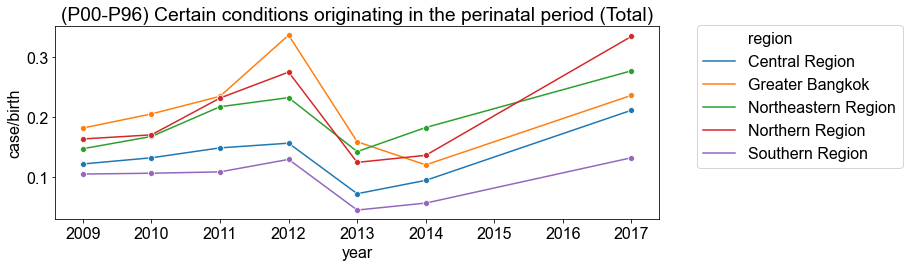

In [309]:
_, ax = plt.subplots(1,1, figsize=(13,4))

df = one_disease[one_disease['gender']=='Total']
#df = df[df['region'] !='Greater Bangkok']
sns.lineplot(data=df, x='year', y='rate', hue='region', ax=ax , marker='o')

title = dis = '(P00-P96) Certain conditions originating in the perinatal period '

ax.set_title(dis + '(Total)')
ax.legend(bbox_to_anchor=(1.05, 1.05))
ax.set_ylabel('case/birth')
    
plt.tight_layout()

plt.savefig(mdataset.report_folder + 'outpat_birth_p.png', dpi=300)

In [327]:
# select year 
temp = out_pat[out_pat['year'].isin([2017])]
mean_rate = temp.groupby(['year', 'gender', 'disease', 'province']).sum()

# calcule rate
mean_rate['rate'] = mean_rate['number']/mean_rate['birth_number']*1000

# reset index
mean_rate = mean_rate.reset_index()
mean_rate = mean_rate[mean_rate['disease'] == dis]

# average of the rate
std_rate = mean_rate.groupby([ 'gender', 'disease', 'province'], as_index=False).std()
mean_rate = mean_rate.groupby([ 'gender', 'disease', 'province'], as_index=False).mean()

mean_rate = mean_rate.merge(std_rate, on=[ 'gender', 'disease', 'province'], suffixes=('', '_std'))

print(mean_rate.shape)

# create a map of pollution by merging with the shape file 
plot_map = mdataset.prov_map.merge(mean_rate, on='province', how='left')
plot_map

(77, 15)


,admin1Name_en,admin1Name_th,admin1Pcode,admin1RefName,admin1AltName1_en,admin1AltName2_en,admin1AltName1_th,admin1AltName2_th,admin0Name_en,admin0Name_th,...,number,pop,birth_number,rate,year_std,code_std,number_std,pop_std,birth_number_std,rate_std
0,Amnat Charoen,อำนาจเจริญ,TH37,None,None,None,None,None,Thailand,ประเทศไทย,...,2207.005857,756214.0,6062.0,364.072230,NaN,NaN,NaN,NaN,NaN,NaN
1,Ang Thong,อ่างทอง,TH15,None,None,None,None,None,Thailand,ประเทศไทย,...,744.002644,562374.0,4056.0,183.432604,NaN,NaN,NaN,NaN,NaN,NaN
2,Bangkok,กรุงเทพมหานคร,TH10,None,None,None,None,None,Thailand,ประเทศไทย,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Bueng Kan,บึงกาฬ,TH38,None,None,None,None,None,Thailand,ประเทศไทย,...,3545.008406,846064.0,7396.0,479.314279,NaN,NaN,NaN,NaN,NaN,NaN
4,Buri Ram,บุรีรัมย์,TH31,None,None,None,None,None,Thailand,ประเทศไทย,...,7638.004809,3183810.0,26604.0,287.099865,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,Udon Thani,อุดรธานี,TH41,None,None,None,None,None,Thailand,ประเทศไทย,...,4992.003169,3166184.0,28130.0,177.461897,NaN,NaN,NaN,NaN,NaN,NaN
73,Uthai Thani,อุทัยธานี,TH61,None,None,None,None,None,Thailand,ประเทศไทย,...,2155.006537,659884.0,4954.0,435.003338,NaN,NaN,NaN,NaN,NaN,NaN
74,Uttaradit,อุตรดิตถ์,TH53,None,None,None,None,None,Thailand,ประเทศไทย,...,1533.003357,914184.0,6194.0,247.498120,NaN,NaN,NaN,NaN,NaN,NaN
75,Yala,ยะลา,TH95,None,None,None,None,None,Thailand,ประเทศไทย,...,2448.004677,1054590.0,20926.0,116.983880,NaN,NaN,NaN,NaN,NaN,NaN


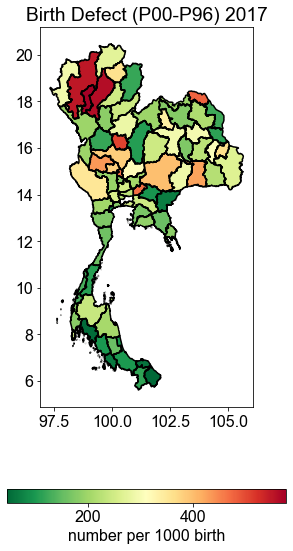

In [330]:
_, ax = plt.subplots(1, 1, figsize=(5,10))

df = plot_map[plot_map['gender']=='Total']

df.plot(column='rate',
           ax=ax,legend=True,
           legend_kwds={'label': "number per 1000 birth",
                       'orientation': "horizontal"},  cmap='RdYlGn_r',
             missing_kwds={
         "color": "lightgrey",
         "edgecolor": "red",
            "hatch": "///",
           "label": "Missing values" })

 
df.boundary.plot(ax=ax, color='black')


ax.set_title("Birth Defect (P00-P96) 2017");

plt.savefig(mdataset.report_folder + 'outpat_birth_map.png', dpi=300)

In [331]:
# select year 
temp = out_pat[out_pat['year'].isin(np.arange(2007,2020))]
mean_rate = temp.groupby(['year', 'gender', 'disease', 'province']).sum()
mean_rate = mean_rate[mean_rate['birth_number'] > 0]

# calcule rate
mean_rate['rate'] = mean_rate['number']/mean_rate['birth_number']*1000

# reset index
mean_rate = mean_rate.reset_index()
mean_rate = mean_rate[mean_rate['disease'] == dis]
 
# average of the rate
std_rate = mean_rate.groupby([ 'gender', 'disease', 'province'], as_index=False).std()

mean_rate = mean_rate.groupby([ 'gender', 'disease', 'province'], as_index=False).mean()


mean_rate = mean_rate.merge(std_rate, on=[ 'gender', 'disease', 'province'], suffixes=('', '_std'))
mean_rate

,gender,disease,province,year,code,number,pop,birth_number,rate,year_std,code_std,number_std,pop_std,birth_number_std,rate_std
0,Total,ภาวะผิดปกติของทารกที่เกิดขึ้นในระยะปริกำเนิด (...,Amnat Charoen,2012.285714,32,1314.003524,7.476746e+05,6932.571429,191.954852,2.690371,0.0,571.816182,4906.391982,560.256744,93.919929
1,Total,ภาวะผิดปกติของทารกที่เกิดขึ้นในระยะปริกำเนิด (...,Ang Thong,2012.285714,32,1491.433809,5.674877e+05,5307.428571,269.478401,2.690371,0.0,900.018857,2492.916212,694.792741,141.515734
2,Total,ภาวะผิดปกติของทารกที่เกิดขึ้นในระยะปริกำเนิด (...,Bueng Kan,2013.400000,32,3198.007728,8.312324e+05,8920.800000,370.060297,2.302173,0.0,696.462425,11696.764031,1301.874495,120.916713
3,Total,ภาวะผิดปกติของทารกที่เกิดขึ้นในระยะปริกำเนิด (...,Buri Ram,2012.285714,32,4959.003160,3.134561e+06,31325.142857,163.573886,2.690371,0.0,2892.212914,31174.086198,2489.825391,103.486732
4,Total,ภาวะผิดปกติของทารกที่เกิดขึ้นในระยะปริกำเนิด (...,Chachoengsao,2012.285714,32,1766.859732,1.372457e+06,16208.285714,111.702298,2.690371,0.0,905.056421,27775.717041,1061.694513,66.362731
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,Total,ภาวะผิดปกติของทารกที่เกิดขึ้นในระยะปริกำเนิด (...,Udon Thani,2012.285714,32,4118.288367,3.116139e+06,32271.142857,128.340992,2.690371,0.0,1165.557799,31120.106338,2137.632291,38.037801
72,Total,ภาวะผิดปกติของทารกที่เกิดขึ้นในระยะปริกำเนิด (...,Uthai Thani,2012.285714,32,1335.146911,6.578489e+05,6059.714286,230.645395,2.690371,0.0,666.455427,1969.551847,591.883354,137.213916
73,Total,ภาวะผิดปกติของทารกที่เกิดขึ้นในระยะปริกำเนิด (...,Uttaradit,2012.285714,32,2055.147292,9.218257e+05,7438.000000,272.981594,2.690371,0.0,891.490270,3837.680971,629.442081,105.479854
74,Total,ภาวะผิดปกติของทารกที่เกิดขึ้นในระยะปริกำเนิด (...,Yala,2012.285714,32,1342.288454,1.002183e+06,21393.714286,64.572202,2.690371,0.0,1221.640979,31641.286314,1179.216366,60.936205


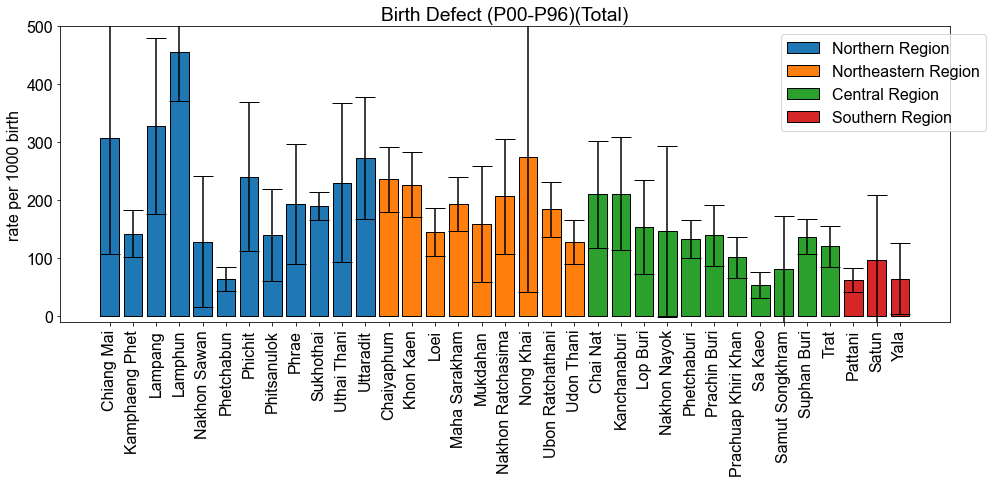

In [335]:
fig, ax = plt.subplots(1,1, figsize=(14, 7), sharex=True)
#ax.bar(pm10_short_list['province'], pm10_short_list['avgPM10'])


for region in region_list:
    # select province
    prov_in_region = provinces[provinces['region'] == region]['province'].to_list()
    # select only province near Chiang Mai
    # use province_list to keep the bar plot in the same order

    prov_in_region = [s for s in near_income_list if s in prov_in_region]
    df = mean_rate[mean_rate['province'].isin(prov_in_region) & (mean_rate['gender'] == 'Total')]
     
    if len(df) > 0:
        ax.bar(df['province'], df['rate'], yerr=df['rate_std'], label=region, edgecolor='black', capsize=10)
        
        
# highlight Chiang Mai
#df = dead_male_short.loc[['Chiang Mai']]
#ax[0].bar(df.index, df['lung_dead'], color='magenta', label='Chiang Mai', edgecolor='black')

#df = dead_female_short.loc[['Chiang Mai']]
#ax[1].bar(df.index, df['lung_dead'], color='magenta', label='Chiang Mai', edgecolor='black')

 
ax.legend(bbox_to_anchor=(1.05, 1.0))
plt.draw()
ax.set_title('Birth Defect (P00-P96)(Total)')
ax.set_ylabel('rate per 1000 birth')
 
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
ax.set_ylim([-10, 500])

plt.tight_layout()
plt.savefig(mdataset.report_folder + 'outpat_birth_bar.png', dpi=300)

## Modeling

In [440]:
population = pd.read_csv(mdataset.health_folder  + 'process/pop_prov.csv')  
population = population.drop(['province_th', 'gender_th'], axis=1)

pop = population.melt(id_vars=['province', 'gender'], var_name='year', value_name='pop')
pop['year'] = pop['year'].astype(int)
out_pat = pd.read_csv(mdataset.health_folder + 'process/out_patient_2007_2019.csv').dropna()
out_pat['gender'] = 'Total'
# add population 
out_pat = out_pat.merge(pop, on=['province', 'gender', 'year'], how='left')

# add birth rate

birth_rate = pd.read_csv(mdataset.health_folder  + 'process/birth_prov.csv')
birth_rate = birth_rate.rename(columns={'number':'birth_number'})
birth_rate['year'] = birth_rate['year'].astype(int)


out_pat = out_pat.merge(birth_rate, on=['province',  'year'], how='left')

# load provinces & region information 
provinces = mdataset.prov_map[['region', 'province']]

region_list = ['Northern Region', 'Northeastern Region', 'Central Region','Greater Bangkok','Southern Region']

# add region
out_pat = out_pat.merge(provinces, on='province', how='left')

In [441]:
dis_list = ['ภาวะผิดปกติของทารกที่เกิดขึ้นในระยะปริกำเนิด (อายุครรภ์ 22 สัปดาห์ขึ้นไปจนถึง 7 วันหลังคลอด) (P00-P96) Certain conditions originating in the perinatal period ',
 'รูปร่างผิดปกติแต่กำเนิด  การพิการจนผิดรูปแต่กำเนิดและโครโมโซม  ผิดปกติ (Q00-Q99) Congenital malformations, deformations and chromosomal abnormalities']


In [442]:
dis = dis_list[0]
print(dis)
in_pat_dis = out_pat[out_pat['disease'] == dis]
in_pat_dis['rate'] = (in_pat_dis['number']/in_pat_dis['pop']*1000).round(2)
in_pat_dis['birth_rate'] = (in_pat_dis['birth_number']/in_pat_dis['pop']*1000).round()
    
data  = build_data_no_gender(in_pat_dis, avg_pm24_prov_noyear)

data = data[data['province'] != 'Bangkok']

ภาวะผิดปกติของทารกที่เกิดขึ้นในระยะปริกำเนิด (อายุครรภ์ 22 สัปดาห์ขึ้นไปจนถึง 7 วันหลังคลอด) (P00-P96) Certain conditions originating in the perinatal period 
data shape (732, 26)


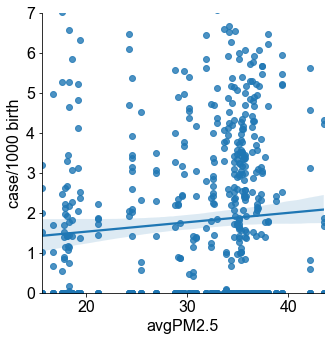

In [445]:
g = sns.lmplot(data=data, x='avgPM2.5', y='rate' )
g.set(ylim=(0, 7))
g.axes[0,0].set_ylabel('case/1000 birth')


plt.savefig(mdataset.report_folder + 'outpat_birth_p_ln_model.png', dpi=300)

In [446]:
# preparing x and y
#x_cols = [ 'income', 'pop_per_avg',   '80-89', 'avgPM2.5' ]
x_cols = [ 'income', 'pop_per_avg',   '20-29', 'birth_rate', 'avgPM2.5' ]
y_cols = 'rate'

df = data_noyear 
x = df[x_cols] 
y = df[y_cols].values

mod = sm.OLS(y, x)    # Describe model
res = mod.fit()       # Fit model
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.715
Model:                            OLS   Adj. R-squared (uncentered):              0.714
Method:                 Least Squares   F-statistic:                              675.1
Date:                Sun, 06 Jun 2021   Prob (F-statistic):                        0.00
Time:                        11:41:21   Log-Likelihood:                         -260.05
No. Observations:                1350   AIC:                                      530.1
Df Residuals:                    1345   BIC:                                      556.1
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
income          0.0229      0.028      0.808      0.419      -0.033       0.079
pop_per_avg     0.1584      0.028      5.652      0.000       0.103       0.213
20-29           0.0178      0.005      3.579      0.000       0.008       0.028
birth_rate     -0.0037      0.002     -2.209      0.027      -0.007      -0.000
avgPM2.5        0.0072      0.001      6.022      0.000       0.005       0.010
==============================================================================
Omnibus:                      396.110   Durbin-Watson:                   1.406
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1052.450
Skew:                           1.536   Prob(JB):                    2.91e-229
Kurtosis:                       6.045   Cond. No.                         160.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""